### Complete Manganese Processing Plant Data Exploration & Analysis
#### Comprehensive EDA for all 10 datasets including beneficiation circuits

#### AUTHOR: DARLENE WENDY NASIMIYU
#### Purpose: Deep dive analysis of complete manganese processing plant data

In [32]:
# Loading necessary Libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tabulate import tabulate

warnings.filterwarnings('ignore')


In [33]:
#----SETUP: Get absolute path ---
BASE_DIR = os.path.dirname(os.getcwd()) # Current working directory of the notebook
data_dir = os.path.join(BASE_DIR, 'data', 'synthetic')

print("Using data directory:", data_dir)


Using data directory: /home/darlenewendie/PycharmProjects/Intelligent-Manganese-Processing-Plant-Optimization/data/synthetic


In [34]:

print("MANGANESE PROCESSING PLANT - COMPREHENSIVE EDA")

MANGANESE PROCESSING PLANT - COMPREHENSIVE EDA


In [35]:
# -----DEFINE DATASET FILES-------
dataset_files = {
    'ore_feed': 'manganese_ore_feed.csv',
    'blended_ore': 'manganese_blended_ore_feed.csv',
    'crushing': 'manganese_crushing_circuit.csv',
    'separation': 'manganese_separation_circuit.csv',
    'flotation': 'manganese_flotation_circuit.csv',
    'dms': 'manganese_dms_circuit.csv',
    'jigging':'manganese_jigging_circuit.csv',
    'dewatering': 'manganese_dewatering_circuit.csv',
    'equipment': 'manganese_equipment_health.csv',
    'energy': 'manganese_energy_consumption.csv',
}
# Load all datasets
datasets = {}
for name, filename in dataset_files.items():
    filepath  = os.path.join(data_dir, filename)
    try:
        df = pd.read_csv(filepath, parse_dates=['timestamp'])
        datasets[name] = df
        print(f" Loaded {name}: {len(df):,} records, {len(df.columns)} columns")
    except FileNotFoundError:
        print(f"Could not find {filepath}")
    except Exception as e:
        print(f"Error loading {name}: {str(e)}")

print(f"\nTotal datasets loaded: {len(datasets)}")
print(f"Total records: {sum(len(df) for df in datasets.values()):,}")

 Loaded ore_feed: 10,000 records, 11 columns
 Loaded blended_ore: 6,522 records, 11 columns
 Loaded crushing: 15,000 records, 9 columns
 Loaded separation: 12,000 records, 13 columns
 Loaded flotation: 12,000 records, 22 columns
 Loaded dms: 8,000 records, 16 columns
 Loaded jigging: 10,000 records, 16 columns
 Loaded dewatering: 8,000 records, 18 columns
 Loaded equipment: 8,000 records, 12 columns
 Loaded energy: 10,000 records, 9 columns

Total datasets loaded: 10
Total records: 99,522


In [36]:
# Create overview data
overview_data = []
for name, df in datasets.items():
    overview_data.append({
        'Dataset': name.replace('_', ' ').title(),
        'Records': len(df),
        'Columns': len(df.columns),
        'Memory (MB)': round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2),
        'Date_range': f"{df['timestamp'].min()} to {df['timestamp'].max()}"
    })

# Create DataFrame after the loop
overview_df = pd.DataFrame(overview_data)

# Display using tabulate
print(tabulate(overview_df, headers='keys', tablefmt='grid', showindex=False))


+-------------+-----------+-----------+---------------+--------------------------------------------+
| Dataset     |   Records |   Columns |   Memory (MB) | Date_range                                 |
+=============+===========+===========+===============+============================================+
| Ore Feed    |     10000 |        11 |          1.29 | 2020-01-01 00:00:00 to 2026-11-04 18:00:00 |
+-------------+-----------+-----------+---------------+--------------------------------------------+
| Blended Ore |      6522 |        11 |          0.84 | 2020-01-01 00:00:00 to 2026-11-04 12:00:00 |
+-------------+-----------+-----------+---------------+--------------------------------------------+
| Crushing    |     15000 |         9 |          1.03 | 2020-01-01 00:00:00 to 2021-09-16 23:00:00 |
+-------------+-----------+-----------+---------------+--------------------------------------------+
| Separation  |     12000 |        13 |          1.73 | 2020-01-01 00:00:00 to 2022-09-26 2

In [37]:
# Load the heads of the datasets
for name, df in datasets.items():
    print(f"========{name} DATASET HEAD===========")
    print(df.head())

========ore_feed DATASET HEAD===========
            timestamp  mn_grade_pct  fe_content_pct  siO2_content_pct  \
0 2020-01-01 00:00:00         71.96           -3.57             -0.60   
1 2020-01-01 06:00:00         59.48            0.14              0.04   
2 2020-01-01 12:00:00         75.30           -4.19             -1.99   
3 2020-01-01 18:00:00         77.71           -4.89             -1.97   
4 2020-01-02 00:00:00         57.79            0.72              0.14   

   al2O3_content_pct  p_content_pct  moisture_pct  p80_mm  work_index_kwh_t  \
0               5.66          0.114           9.0    21.5              22.0   
1               6.91          0.235           9.0    13.9              22.0   
2               5.30          0.154           5.1    19.1              22.0   
3               6.64          0.084           8.8    32.3              22.0   
4               6.75          0.114           9.3    16.1              22.0   

   specific_gravity   ore_type  
0           

In [38]:
from tabulate import tabulate
import numpy as np

def assess_data_quality(df, dataset_name):
    # Header
    print(f"\n======== {dataset_name.replace('_', ' ').title()} QUALITY REPORT ==========")

    # Basic info
    shape = f"{df.shape[0]} rows x {df.shape[1]} columns"
    dtypes = df.dtypes.value_counts().to_dict()

    # Missing values
    missing = df.isnull().sum()
    missing_info = missing[missing > 0].to_dict() if missing.sum() > 0 else "No missing values"

    # Duplicates
    duplicates = df.duplicated().sum()
    duplicates_pct = duplicates / df.shape[0] * 100

    # Numeric column summary (first 5 columns only)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_summary = []
    for col in numeric_cols[:5]:
        numeric_summary.append(f"{col}: {df[col].min():.2f} to {df[col].max():.2f}")

    # Prepare table
    table = [
        ["Shape", shape],
        ["Data type count", dtypes],
        ["Missing values", missing_info],
        ["Duplicated rows", f"{duplicates} ({duplicates_pct:.2f}%)"],
        ["Numeric columns summary", "\n".join(numeric_summary) if numeric_summary else "None"]
    ]

    print(tabulate(table, headers=["Metric", "Value"], tablefmt="grid", showindex=False))

    return {
        'missing_values': missing.sum(),
        'duplicates': duplicates,
        'numeric_columns': len(numeric_cols)
    }

# ASSESS QUALITY OF EACH DATASET
quality_results = {}
for name, df in datasets.items():
    quality_results[name] = assess_data_quality(df, name)



======== Ore Feed QUALITY REPORT ==========
+-------------------------+-----------------------------------------------------------+
| Metric                  | Value                                                     |
+=========================+===========================================================+
| Shape                   | 10000 rows x 11 columns                                   |
+-------------------------+-----------------------------------------------------------+
| Data type count         | {dtype('float64'): 9, dtype('<M8[ns]'): 1, dtype('O'): 1} |
+-------------------------+-----------------------------------------------------------+
| Missing values          | No missing values                                         |
+-------------------------+-----------------------------------------------------------+
| Duplicated rows         | 0 (0.00%)                                                 |
+-------------------------+------------------------------------------------

ORE CHARACTERISTICS DEEP DIVE

ORE CHARACTERISTICS COMPARISON: 
Original Ore - Mean Grade: 62.02% (σ=12.36)
Blended Ore - Mean Grade: 56.61% (σ=11.42)
Blending Impact: -5.40 percentage points


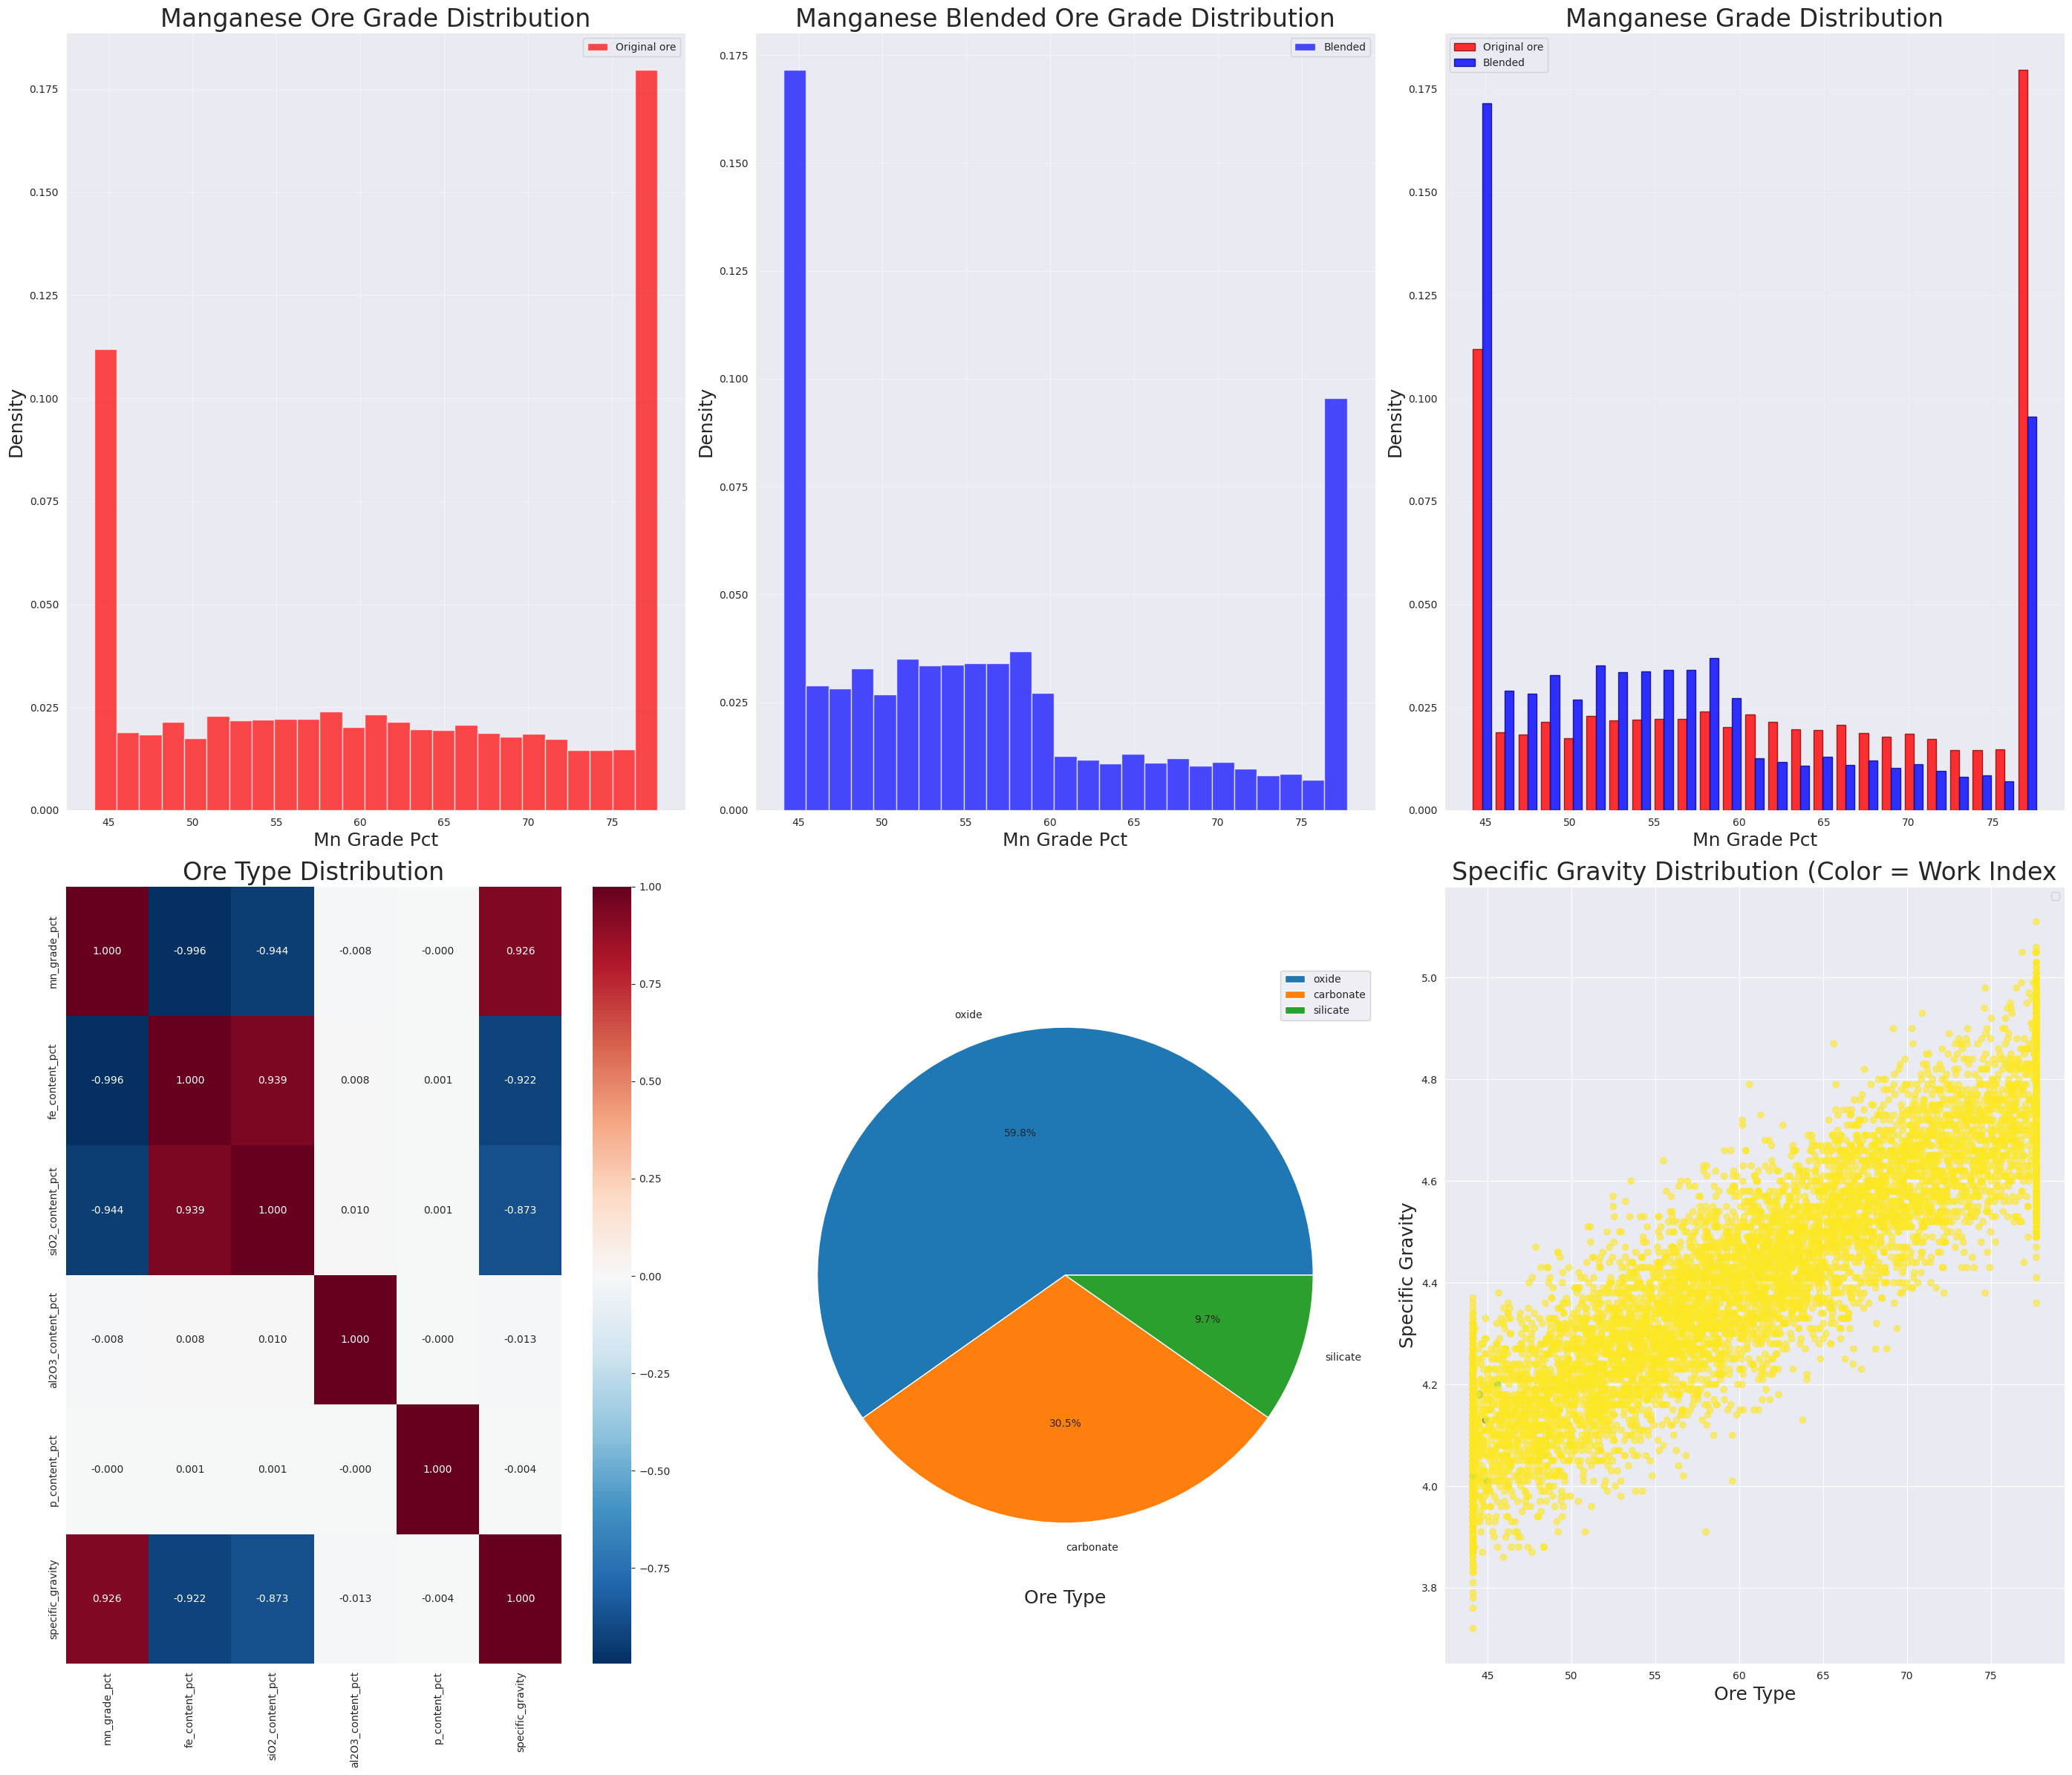

In [41]:
# ORE CHARACTERISTS AND ANALYSIS
print("ORE CHARACTERISTICS DEEP DIVE")

if 'ore_feed' in datasets and 'blended_ore' in datasets:
    ore_df = datasets['ore_feed']
    blended_df = datasets['blended_ore']


    fig, axes = plt.subplots(2,3, figsize=(28,24))

    # Common font sizes
    title_size = 24
    label_size = 18
    tick_size = 16

    # Manganese Grade Distribution in Ore feed
    # Grade distributions
    axes[0,0].hist(ore_df['mn_grade_pct'], bins=25, alpha=0.7, label='Original ore', density=True, color='red')
    axes[0,0].legend()
    axes[0,0].set_xlabel('Mn Grade Pct', fontsize=label_size)
    axes[0,0].set_ylabel('Density', fontsize=label_size)
    axes[0,0].set_title('Manganese Ore Grade Distribution', fontsize=title_size)
    axes[0,0].grid(True, alpha=0.5)

    # Manganese Grade Distribution in Blended Ore
    # Grade distributions
    axes[0,1].hist(blended_df['mn_grade_pct'], bins=25, alpha=0.7, label='Blended', density=True, color='blue')
    axes[0,1].legend()
    axes[0,1].set_xlabel('Mn Grade Pct', fontsize=label_size)
    axes[0,1].set_ylabel('Density', fontsize=label_size)
    axes[0,1].set_title('Manganese Blended Ore Grade Distribution', fontsize=title_size)
    axes[0,1].grid(True, alpha=0.5)

    # Manganese grade distribution comparison with GROUPED BARS
    # Create bins for grouping
    bins = np.linspace(ore_df['mn_grade_pct'].min(), ore_df['mn_grade_pct'].max(), 26)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_width = bins[1] - bins[0]

    # Calculate histogram values for both datasets
    original_counts, _ = np.histogram(ore_df['mn_grade_pct'], bins=bins, density=True)
    blended_counts, _ = np.histogram(blended_df['mn_grade_pct'], bins=bins, density=True)

    # Plot grouped bars
    bar_width = bin_width * 0.4  # Make bars narrower to fit side-by-side
    axes[0,2].bar(bin_centers - bar_width/2, original_counts, width=bar_width,
                  alpha=0.8, label='Original ore', color='red', edgecolor='darkred')
    axes[0,2].bar(bin_centers + bar_width/2, blended_counts, width=bar_width,
                  alpha=0.8, label='Blended', color='blue', edgecolor='darkblue')

    axes[0,2].legend()
    axes[0,2].set_xlabel('Mn Grade Pct', fontsize=label_size)
    axes[0,2].set_ylabel('Density', fontsize=label_size)
    axes[0,2].set_title('Manganese Grade Distribution', fontsize=title_size)
    axes[0,2].grid(True, alpha=0.3)
    #Elements correlation maps
    numeric_cols = ['mn_grade_pct', 'fe_content_pct', 'siO2_content_pct', 'al2O3_content_pct', 'p_content_pct', 'specific_gravity']
    correlation_matrix = ore_df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, ax=axes[1,0], fmt='.3f')
    axes[1,0].set_title('Ore Type Distribution', fontsize=title_size)

    #Ore type distribution
    ore_type_counts = ore_df['ore_type'].value_counts()
    axes[1,1].pie(ore_type_counts.values, labels=ore_type_counts.index.values, autopct='%1.1f%%')
    axes[1,1].legend()
    axes[1,1].set_xlabel('Ore Type', fontsize=label_size)

    # Grade vs Recovery potential (using specific gravity as proxy)
    scatter = axes[1,2].scatter(ore_df['mn_grade_pct'], ore_df['specific_gravity'], c=ore_df['work_index_kwh_t'], cmap='viridis', alpha=0.6)
    axes[1,2].set_title('Specific Gravity Distribution (Color = Work Index', fontsize=title_size)
    axes[1,2].legend()
    axes[1,2].set_xlabel('Ore Type', fontsize=label_size)
    axes[1,2].set_ylabel('Specific Gravity', fontsize=label_size)
    plt.tight_layout()

    #Statistical Comparison
    print(f"\nORE CHARACTERISTICS COMPARISON: ")
    print(f"Original Ore - Mean Grade: {ore_df['mn_grade_pct'].mean():.2f}% (σ={ore_df['mn_grade_pct'].std():.2f})")
    print(f"Blended Ore - Mean Grade: {blended_df['mn_grade_pct'].mean():.2f}% (σ={blended_df['mn_grade_pct'].std():.2f})")

    # Grade Improvement for blending
    grade_improvement = blended_df['mn_grade_pct'].mean() - ore_df['mn_grade_pct'].mean()
    print(f"Blending Impact: {grade_improvement:+.2f} percentage points")

    plt.show()

#### 1. MANGANESE ORE GRADE DISTRIBUTION
- The chart shows original manganese ore grade distribution before any blending or processing. It reveals a bimodal pattern, with a large portion of low-grade ore around 40–45% Mn and another strong peak of high-grade ore near 75% Mn, while mid-range grades (50–65%) are much less common.
- This pattern is typical for manganese deposits due to natural geological variations, where some zones are highly enriched with oxides like pyrolusite and others contain lower-grade material mixed with carbonates and silicates.
- For beneficiation, this variability means that without blending, the plant would experience unstable feed quality, affecting recovery and efficiency. Therefore, a blending strategy is essential to create a more uniform feed for gravity, magnetic, and flotation circuits, ensuring consistent processing performance.

#### 2. MANGANESE BLENDED ORE GRADE DISTRIBUTION
- The chart shows the manganese grade distribution after blending, highlighting a successful reduction in feed variability. Unlike the original ore, which had two extreme peaks of low- and high-grade material, the blended ore now forms a smoother, more uniform range centered around 45–65% Mn.
- This stabilization is crucial for beneficiation, as it ensures that gravity, magnetic, and flotation circuits operate under steady conditions, improving recovery rates and plant efficiency. While some outliers remain, blending has significantly minimized the risks associated with sudden grade fluctuations.


#### 3. COMPARISON BETWEEN ORE FEED GRADE AND BLENDED ORE DISTRIBUTION
- The chart clearly demonstrates the effectiveness of blending by comparing original and blended ore grade distributions. The original ore showed two sharp peaks — a large amount of low-grade material around 40–45% Mn and another high-grade spike near 75% Mn — with very little mid-grade ore in between.
- After blending, the distribution becomes much smoother and centered around 55–60% Mn, reducing the extremes that can disrupt processing. This uniform feed ensures more consistent performance across gravity, magnetic, and flotation circuits, leading to improved recovery rates and stable product quality.


#### 4. ORE TYPE DISTRIBUTION CORRELATION MAP



#### 5. PIE CHART
 - Manganese occurs in nature in many mineral forms, but the most significant for industrial use are oxides, carbonates, and silicates, which directly influence processing methods. In our findings, the ore was predominantly composed of oxides (58.9%), followed by carbonates (30.1%), and silicates (9.7%).
  - Oxides, such as pyrolusite and manganite, are the most common and form the primary source of manganese; they respond well to gravity and magnetic separation, which aligns with our plant setup. Carbonate minerals, like rhodochrosite, are ideal for flotation, justifying the inclusion of flotation circuits for the 30% carbonate fraction. Silicates, like braunite, are harder to process and may require more complex combinations of beneficiation methods.
- This mineralogical breakdown confirms that our current process design—gravity and magnetic separation with a flotation circuit—is well-suited to efficiently treat the ore composition in our deposit (Shanghai Metal Market, 2024).
- SMM Analysis：Types of Manganese Ores.】 - Shanghai Metal Market. (2024). Metal.com. https://www.metal.com/en/newscontent/103020371?

#### 6. SPECIFIC GRAVITY DISTRIBUTION SCATTER PLOT


#### PROCESSS CIRCUIT PERFORMANCE
- A processing circuit in a manganese plant is a sequence of equipment and operations designed to separate valuable manganese ore from waste material.
- Each circuit, such as Gravity Separation, Flotation, Dense Media Separation (DMS), and Jigging, uses a different physical or chemical principle—like density differences or chemical flotation—to maximize both the grade (purity) and recovery (amount extracted) of manganese.
 - Circuits have inputs (feed) and outputs (concentrate and tailings), and their efficiency can be tracked using key performance indicators like overall_recovery or floatation_recovery.
- In data analysis, mapping each circuit to its corresponding recovery column in a dataset allows for programmatic comparison and visualization of how effectively each method contributes to manganese beneficiation.



PROCESS CIRCUIT PERFORMANCE ANALYSIS


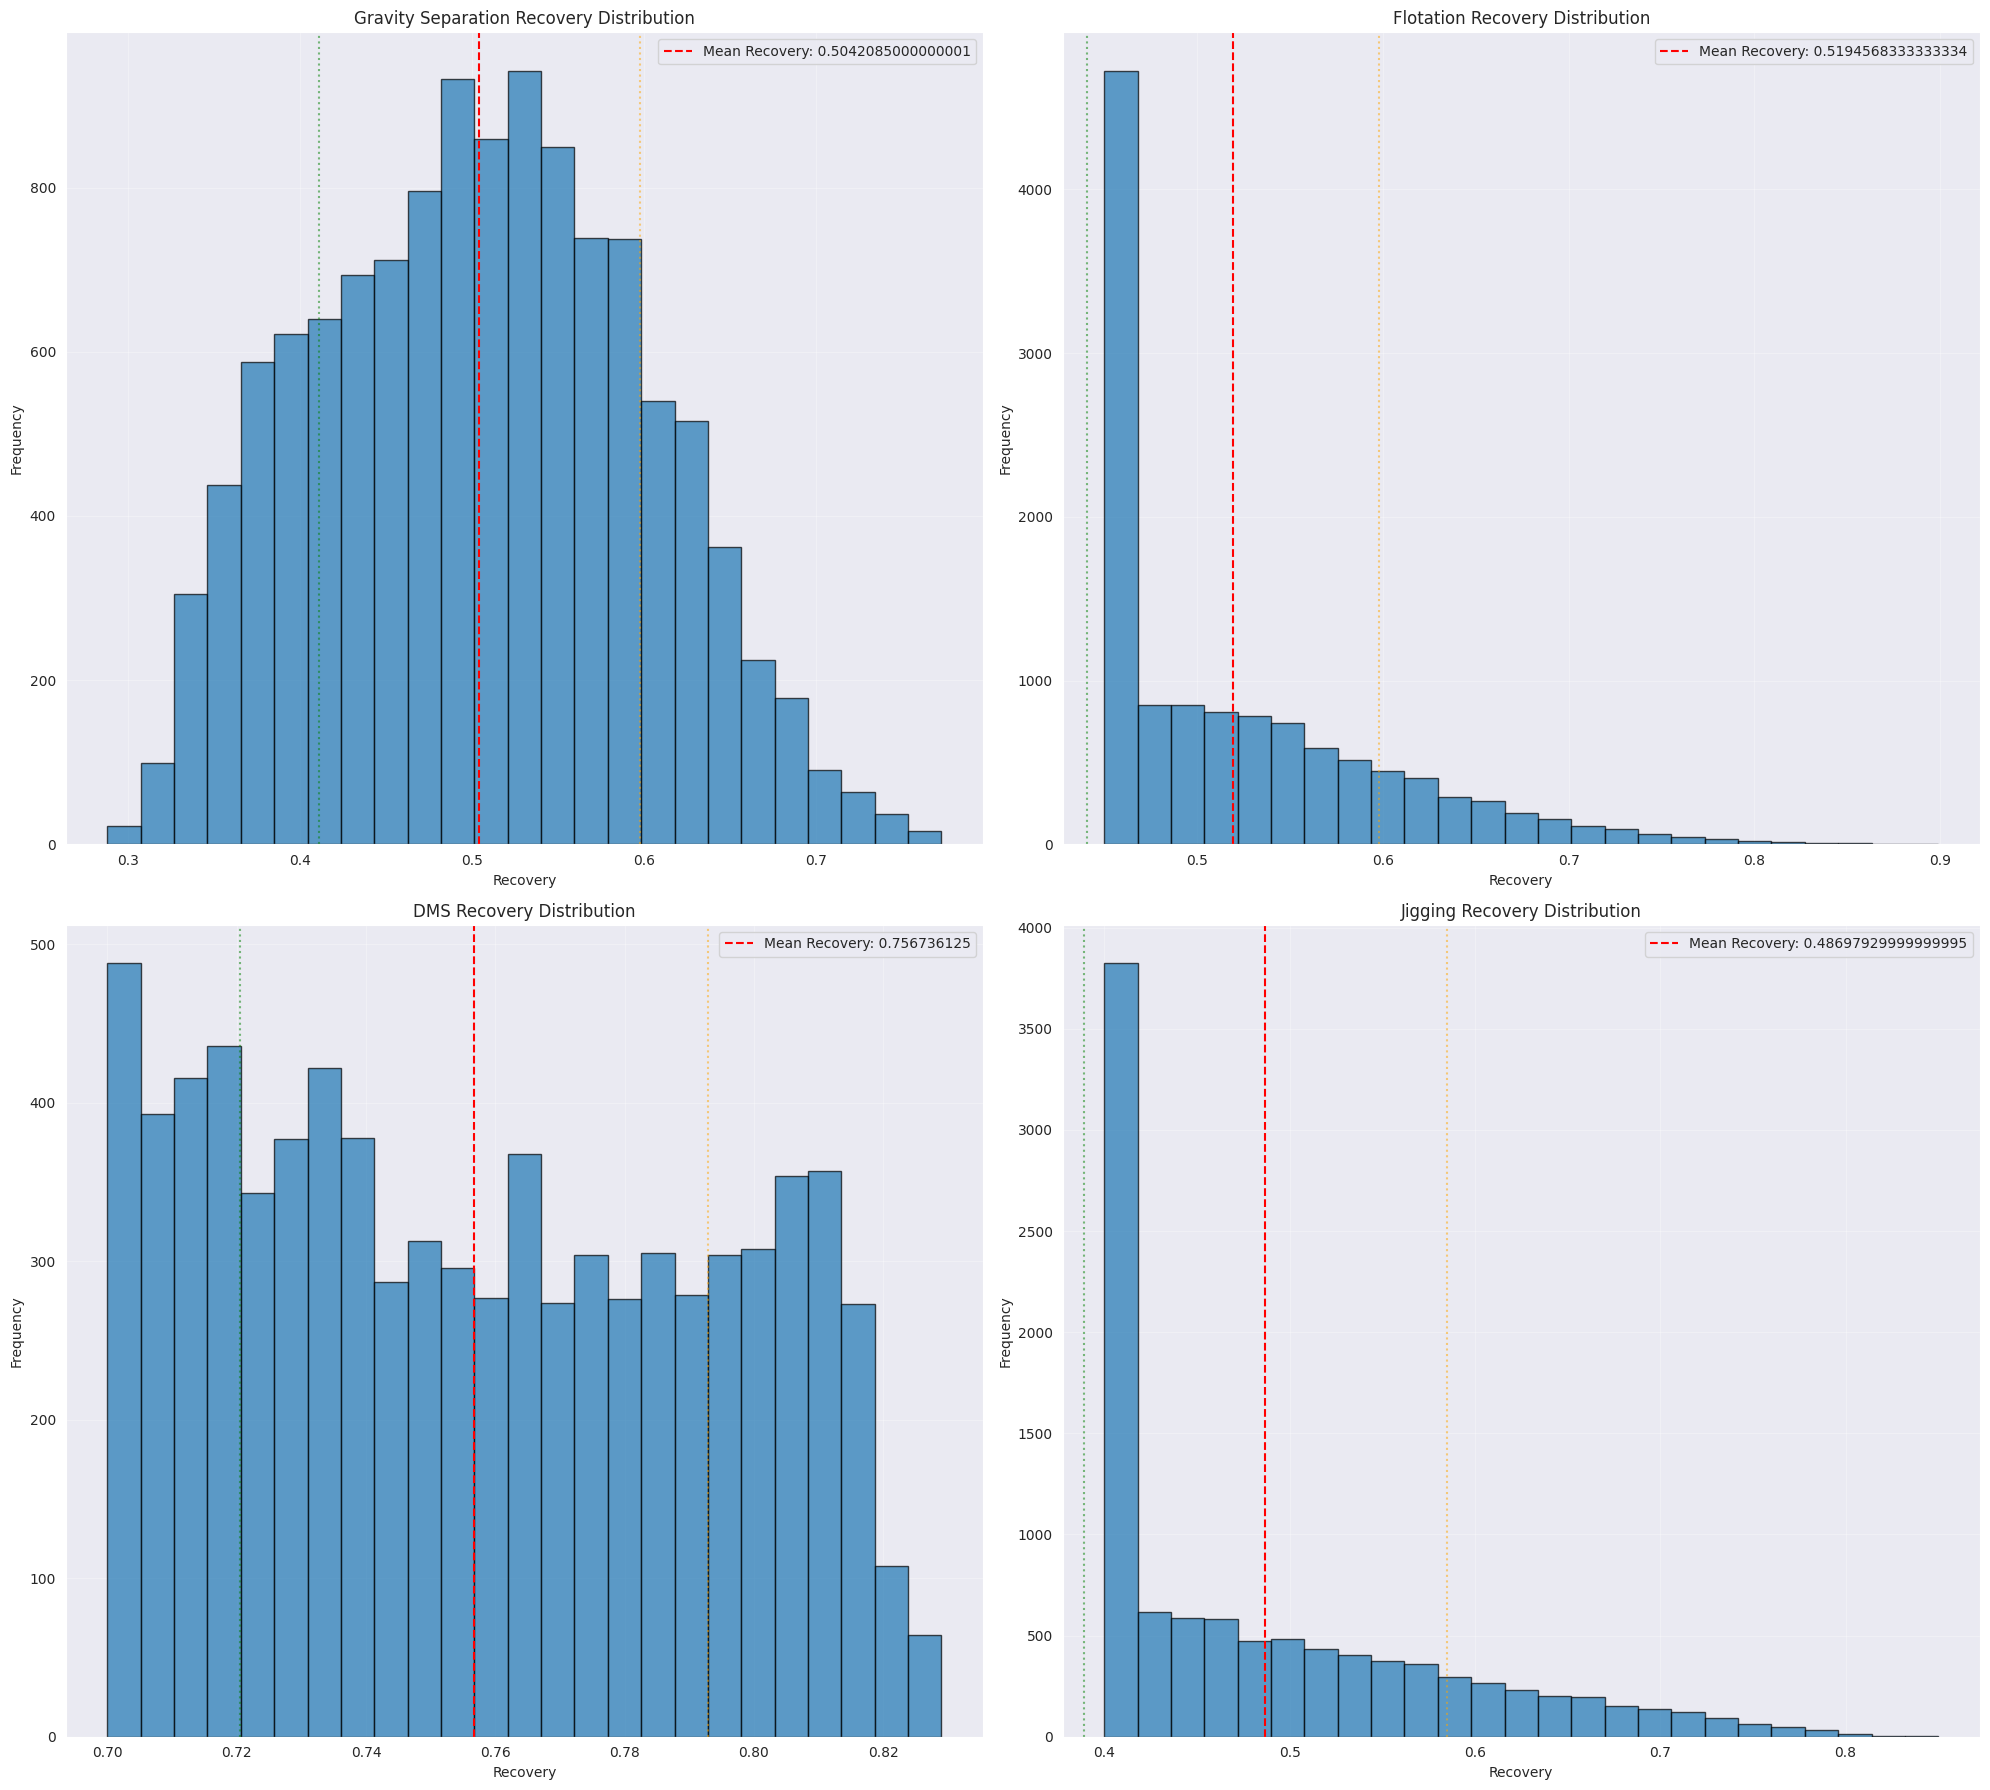


RECOVERY SUMMARY:
           Circuit  Mean Recovery  Standard Deviation   Min   Max  Count
Gravity Separation         0.5042              0.0934 0.288 0.773  12000
         Flotation         0.5195              0.0787 0.450 0.899  12000
               DMS         0.7567              0.0362 0.700 0.829   8000
           Jigging         0.4870              0.0980 0.400 0.850  10000


In [46]:
#PROCESS CIRCUIT PERFORMANCE
#N/B: DMS= Dense Media Separation
print("\n" + "=" * 60)
print(f"\nPROCESS CIRCUIT PERFORMANCE ANALYSIS")
print("=" * 60)

recovery_data = []
circuits = {
    'Gravity Separation': ('separation', 'overall_recovery'),
    'Flotation': ('flotation', 'flotation_recovery'),
    'DMS': ('dms','dms_recovery'),
    'Jigging':('jigging','jig_recovery')
}

fig, axes = plt.subplots(2,2, figsize=(20,18))
axes = axes.ravel()

for i, (circuit_name,(dataset_key, recovery_col)) in enumerate(circuits.items()):
    if dataset_key in datasets and recovery_col in datasets[dataset_key].columns:
        df = datasets[dataset_key]
        recovery =df[recovery_col]

        #Distribution plot
        axes[i].hist(recovery, bins= 25, alpha=0.7, edgecolor='black')
        axes[i].set_xlabel('Recovery')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f"{circuit_name} Recovery Distribution")
        axes[i].grid(True, alpha=0.3)

        # Statistics
        mean_recovery = recovery.mean()
        std_recovery = recovery.std()
        axes[i].axvline(mean_recovery, color='red', linestyle='--', label=f'Mean Recovery: {mean_recovery}')
        axes[i].axvline(mean_recovery + std_recovery, color='orange', linestyle=':', alpha=0.5)
        axes[i].axvline(mean_recovery - std_recovery, color='green', linestyle=':', alpha=0.5)
        axes[i].legend()
        recovery_data.append({
            'Circuit': circuit_name,
            'Mean Recovery': mean_recovery,
            'Standard Deviation': std_recovery,
            'Min': recovery.min(),
            'Max': recovery.max(),
            'Count': len(recovery)
        })
plt.tight_layout()
plt.show()

#Summary table
if recovery_data:
    recovery_summary = pd.DataFrame(recovery_data)
    print(f"\nRECOVERY SUMMARY:")
    print(recovery_summary.round(4).to_string(index=False))


1. Gravity Separation

- The histogram shows gravity separation achieving a mean recovery of about 50.42%, with a fairly symmetrical distribution, reflecting the expected theoretical performance of this method. Gravity separation relies on density differences between manganese ore and gangue, and typically yields 40–60% recovery depending on particle size distribution (Wills & Finch, 2016). Its stability in the graph indicates reliability, but the relatively modest recovery confirms that gravity separation alone cannot achieve optimal plant performance, especially for fine ores where settling efficiency declines.

2. Flotation

- The flotation histogram displays a mean recovery of ~51.92%, but with a pronounced right-skew, showing a large number of lower recoveries around 0.45–0.55 and occasional peaks reaching up to 0.90. This variability aligns with flotation theory, where performance is highly sensitive to pulp chemistry, reagent dosages, and particle size effects (Fuerstenau et al., 2007). Although flotation can theoretically deliver 50–80% recovery, the graph emphasizes its instability, suggesting that without optimization, flotation introduces inconsistency in manganese plant operations.

3. Dense Media Separation (DMS)

- Dense Media Separation emerges as the best-performing circuit in the dataset, with a mean recovery of ~78.87% and a narrow spread, consistent with its theoretical recovery range of 70–85% (Mukherjee & Mishra, 2006). The histogram indicates both high efficiency and operational stability, confirming DMS as a robust beneficiation method for manganese ore. Given its ability to consistently separate ore based on density, the data suggests DMS should serve as the core recovery stage in the manganese processing plant, with optimization focused on fine-tuning medium density and particle size ranges.

4. Jigging

- The jigging histogram reveals a mean recovery of ~48.5%, with a strong left skew caused by a concentration of values near 0.40, demonstrating frequent underperformance. This aligns with jigging’s theoretical limitations, where recoveries usually range between 40–55% and efficiency depends heavily on water flow and feed size (Burt, 1984). While jigging remains a low-cost and historically important method, the graph confirms its inconsistency and poor competitiveness compared to DMS. In practice, jigging may be more useful as a pre-concentration stage rather than a final recovery method in a modern manganese plant.


EQUIPMENT HEALTH ANALYSIS


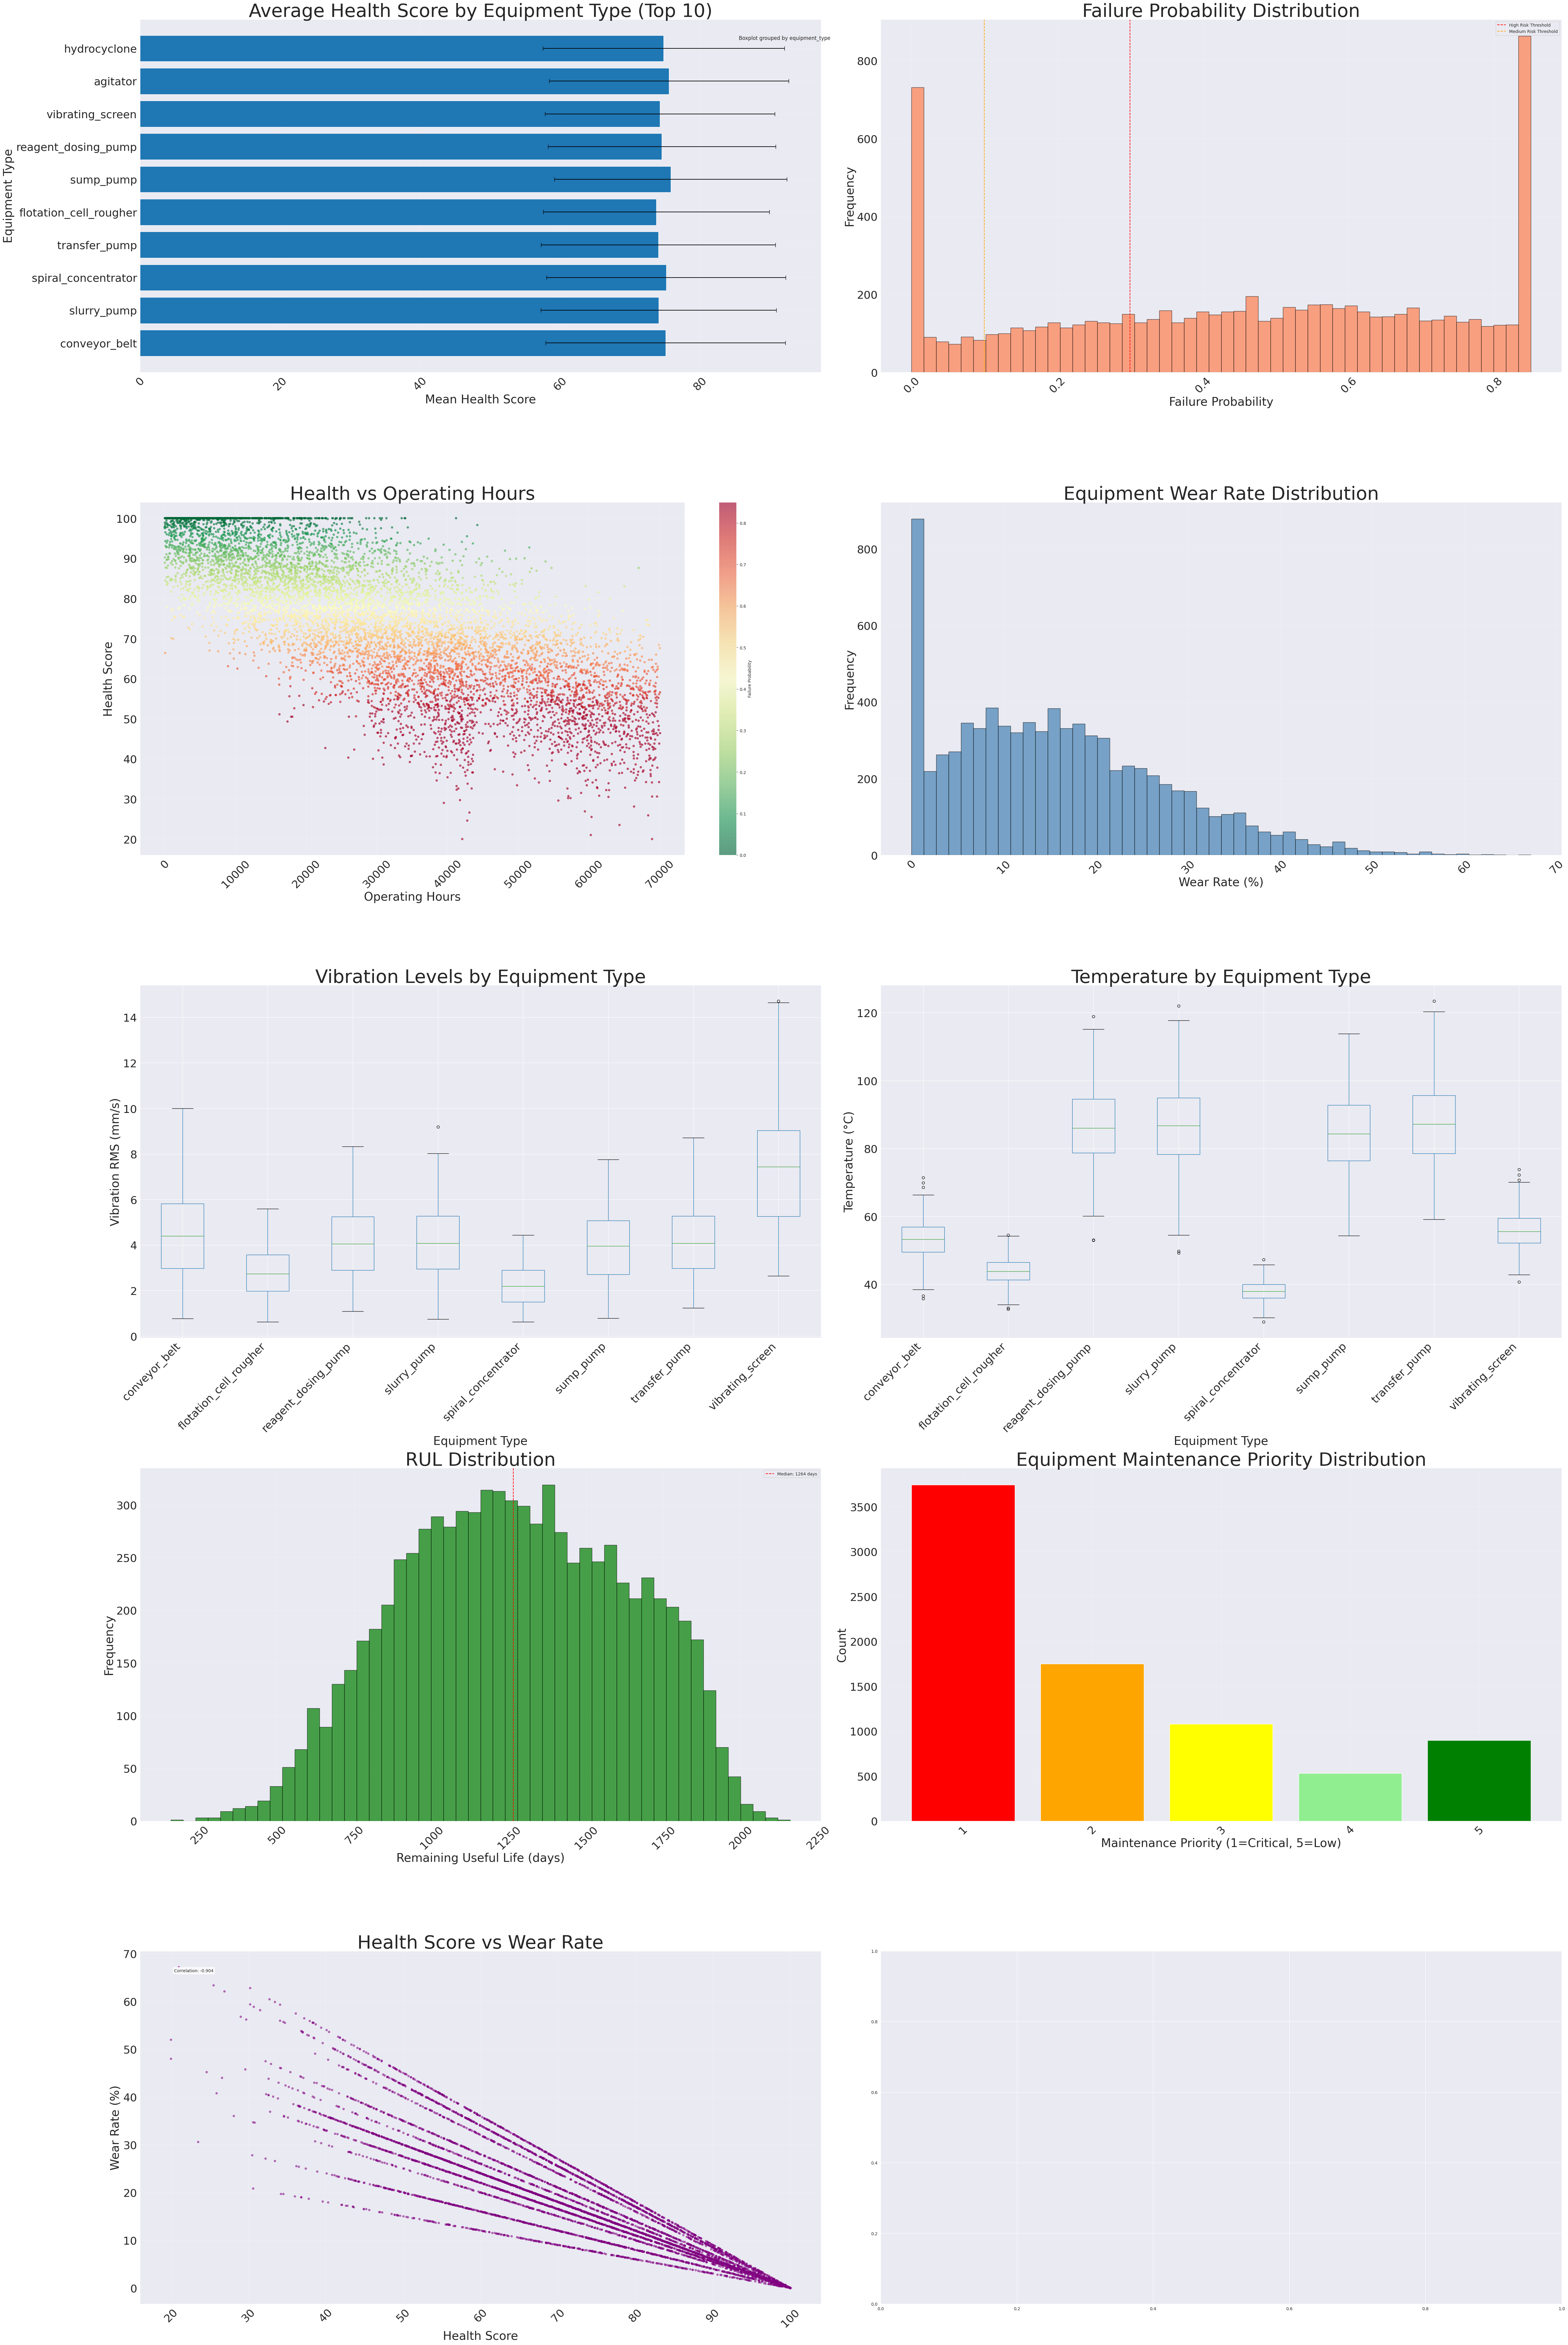


EQUIPMENT HEALTH STATISTICS (Top 15 Equipment Types):
                          mean    std  count
equipment_type                              
conveyor_belt            75.10  17.13    924
slurry_pump              74.10  16.82    771
spiral_concentrator      75.18  17.08    528
transfer_pump            74.06  16.72    478
flotation_cell_rougher   73.75  16.15    374
sump_pump                75.83  16.60    354
reagent_dosing_pump      74.56  16.26    353
vibrating_screen         74.30  16.41    320
agitator                 75.58  17.09    299
hydrocyclone             74.83  17.27    269
flotation_cell_cleaner   74.39  16.90    267
apron_feeder             75.14  15.15    256
magnetic_separator_lims  73.39  16.13    234
air_blower               73.12  16.45    233
jig                      75.04  17.58    223

RISK CATEGORIZATION:
High Risk (>30%): 5492 units (68.7%)
Medium Risk (10-30%): 1374 units (17.2%)
Low Risk (<10%): 1134 units (14.2%)

EQUIPMENT INVENTORY:
Total Equipment Types:

In [59]:
# %%
# STEP 7: EQUIPMENT HEALTH ANALYSIS
print("\n" + "=" * 60)
print("EQUIPMENT HEALTH ANALYSIS")
print("=" * 60)

if 'equipment' in datasets:
    equipment_df = datasets['equipment']

    fig, axes = plt.subplots(5, 2, figsize=(52, 78))
    axes = axes.ravel()

    # Common font sizes
    title_size = 44
    label_size = 28
    tick_size = 26

    # Health score by equipment type (top 10 most common)
    health_by_type = equipment_df.groupby('equipment_type')['health_score'].agg(['mean', 'std', 'count'])
    health_by_type_sorted = health_by_type.nlargest(10, 'count')

    axes[0].barh(health_by_type_sorted.index, health_by_type_sorted['mean'],
                 xerr=health_by_type_sorted['std'], capsize=5)
    axes[0].set_xlabel('Mean Health Score', fontsize=label_size)
    axes[0].set_ylabel('Equipment Type', fontsize=label_size)
    axes[0].set_title('Average Health Score by Equipment Type (Top 10)', fontsize=title_size)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45, labelsize=tick_size)
    axes[0].tick_params(axis='y', labelsize=tick_size)

    # Failure probability distribution
    axes[1].hist(equipment_df['failure_probability'], bins=50, alpha=0.7, edgecolor='black', color='coral')
    axes[1].axvline(0.3, color='red', linestyle='--', label='High Risk Threshold')
    axes[1].axvline(0.1, color='orange', linestyle='--', label='Medium Risk Threshold')
    axes[1].set_xlabel('Failure Probability', fontsize=label_size)
    axes[1].set_ylabel('Frequency', fontsize=label_size)
    axes[1].set_title('Failure Probability Distribution', fontsize=title_size)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45, labelsize=tick_size)
    axes[1].tick_params(axis='y', labelsize=tick_size)

    # Operating hours vs health score
    scatter = axes[2].scatter(equipment_df['operating_hours'], equipment_df['health_score'],
                            c=equipment_df['failure_probability'], cmap='RdYlGn_r', alpha=0.6, s=20)
    axes[2].set_xlabel('Operating Hours', fontsize=label_size)
    axes[2].set_ylabel('Health Score', fontsize=label_size)
    axes[2].set_title('Health vs Operating Hours', fontsize=title_size)
    plt.colorbar(scatter, ax=axes[2], label='Failure Probability')
    axes[2].grid(True, alpha=0.3)
    axes[2].tick_params(axis='x', rotation=45, labelsize=tick_size)
    axes[2].tick_params(axis='y', labelsize=tick_size)

    # Wear rate distribution
    if 'wear_rate_pct' in equipment_df.columns:
        axes[3].hist(equipment_df['wear_rate_pct'], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
        axes[3].set_xlabel('Wear Rate (%)', fontsize=label_size)
        axes[3].set_ylabel('Frequency', fontsize=label_size)
        axes[3].set_title('Equipment Wear Rate Distribution', fontsize=title_size)
        axes[3].grid(True, alpha=0.3)
        axes[3].tick_params(axis='x', rotation=45, labelsize=tick_size)
        axes[3].tick_params(axis='y', labelsize=tick_size)

    # Vibration analysis by equipment category
    equipment_categories = equipment_df['equipment_type'].value_counts().nlargest(8).index
    vibration_data = equipment_df[equipment_df['equipment_type'].isin(equipment_categories)]
    vibration_data.boxplot(column='vibration_rms', by='equipment_type', ax=axes[4])
    axes[4].set_xlabel('Equipment Type', fontsize=label_size)
    axes[4].set_ylabel('Vibration RMS (mm/s)', fontsize=label_size)
    axes[4].set_title('Vibration Levels by Equipment Type', fontsize=title_size)
    axes[4].tick_params(axis='x', rotation=45, labelsize=tick_size)
    axes[4].tick_params(axis='y', labelsize=tick_size)
    plt.sca(axes[4])
    plt.xticks(rotation=45, ha='right')

    # Temperature analysis
    temp_data = equipment_df[equipment_df['equipment_type'].isin(equipment_categories)]
    temp_data.boxplot(column='temperature_c', by='equipment_type', ax=axes[5])
    axes[5].set_xlabel('Equipment Type', fontsize=label_size)
    axes[5].set_ylabel('Temperature (°C)', fontsize=label_size)
    axes[5].set_title('Temperature by Equipment Type', fontsize=title_size)
    axes[5].tick_params(axis='x', rotation=45, labelsize=tick_size)
    axes[5].tick_params(axis='y', labelsize=tick_size)
    plt.sca(axes[5])
    plt.xticks(rotation=45, ha='right')

    # Remaining useful life distribution
    axes[6].hist(equipment_df['rul_days'], bins=50, alpha=0.7, edgecolor='black', color='green')
    axes[6].axvline(equipment_df['rul_days'].median(), color='red', linestyle='--',
                   label=f'Median: {equipment_df["rul_days"].median():.0f} days')
    axes[6].set_xlabel('Remaining Useful Life (days)', fontsize=label_size)
    axes[6].set_ylabel('Frequency', fontsize=label_size)
    axes[6].set_title('RUL Distribution', fontsize=title_size)
    axes[6].tick_params(axis='x', rotation=45, labelsize=tick_size)
    axes[6].tick_params(axis='y', labelsize=tick_size)
    axes[6].legend()
    axes[6].grid(True, alpha=0.3)

    # Maintenance priority distribution
    if 'maintenance_priority' in equipment_df.columns:
        priority_counts = equipment_df['maintenance_priority'].value_counts().sort_index()
        axes[7].bar(priority_counts.index, priority_counts.values, color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
        axes[7].set_xlabel('Maintenance Priority (1=Critical, 5=Low)', fontsize=label_size)
        axes[7].set_ylabel('Count', fontsize=label_size)
        axes[7].set_title('Equipment Maintenance Priority Distribution', fontsize=title_size)
        axes[7].grid(True, alpha=0.3)
        axes[7].tick_params(axis='x', rotation=45, labelsize=tick_size)
        axes[7].tick_params(axis='y', labelsize=tick_size)

    # Health vs Wear correlation
    if 'wear_rate_pct' in equipment_df.columns:
        axes[8].scatter(equipment_df['health_score'], equipment_df['wear_rate_pct'],
                       alpha=0.5, s=20, c='purple')
        axes[8].set_xlabel('Health Score', fontsize=label_size)
        axes[8].set_ylabel('Wear Rate (%)', fontsize=label_size)
        axes[8].set_title('Health Score vs Wear Rate', fontsize=title_size)
        axes[8].grid(True, alpha=0.3)
        axes[8].tick_params(axis='x', rotation=45, labelsize=tick_size)
        axes[8].tick_params(axis='y', labelsize=tick_size)

        # Add correlation coefficient
        corr = equipment_df['health_score'].corr(equipment_df['wear_rate_pct'])
        axes[8].text(0.05, 0.95, f'Correlation: {corr:.3f}',
                    transform=axes[8].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Equipment health statistics
    print("\nEQUIPMENT HEALTH STATISTICS (Top 15 Equipment Types):")
    print(health_by_type.nlargest(15, 'count').round(2))

    # Risk categorization
    high_risk = len(equipment_df[equipment_df['failure_probability'] > 0.3])
    medium_risk = len(equipment_df[(equipment_df['failure_probability'] > 0.1) &
                                  (equipment_df['failure_probability'] <= 0.3)])
    low_risk = len(equipment_df[equipment_df['failure_probability'] <= 0.1])

    print(f"\nRISK CATEGORIZATION:")
    print(f"High Risk (>30%): {high_risk} units ({high_risk/len(equipment_df)*100:.1f}%)")
    print(f"Medium Risk (10-30%): {medium_risk} units ({medium_risk/len(equipment_df)*100:.1f}%)")
    print(f"Low Risk (<10%): {low_risk} units ({low_risk/len(equipment_df)*100:.1f}%)")

    # Equipment type summary
    print(f"\nEQUIPMENT INVENTORY:")
    print(f"Total Equipment Types: {equipment_df['equipment_type'].nunique()}")
    print(f"Total Equipment Units: {equipment_df['equipment_id'].nunique()}")
    print(f"Average Health Score: {equipment_df['health_score'].mean():.1f}")
    print(f"Average Wear Rate: {equipment_df['wear_rate_pct'].mean():.1f}%" if 'wear_rate_pct' in equipment_df.columns else "")

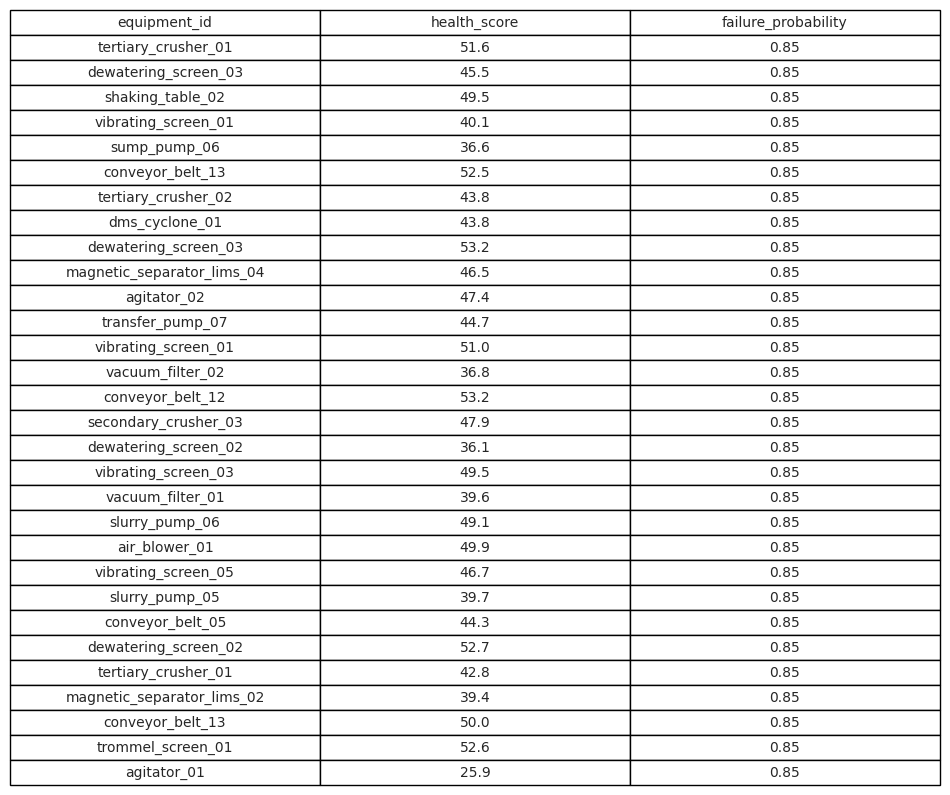

In [68]:
# Sort equipment by failure probability (descending = riskiest first)
top_risky = equipment_df[['equipment_id', 'health_score', 'failure_probability']] \
    .sort_values(by='failure_probability', ascending=False) \
    .head(30)  # Top 10 riskiest equipment

# Create a new figure for the table
fig_table, ax_table = plt.subplots(figsize=(8, 3))
ax_table.axis('off')  # Hide axis

# Build the table
table = ax_table.table(cellText=top_risky.values,
                       colLabels=top_risky.columns,
                       cellLoc='center',
                       loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.5, 1.5)  # (width, height scaling)

plt.show()

1. Average Health Score by Equipment Type (Top 10)
- This analysis highlights the plant’s overall mechanical resilience by ranking the top ten equipment categories with the highest average health scores, a metric derived from the ratio of operating hours to expected lifespan.
- Rooted in reliability engineering principles, the calculation recognizes that equipment degrades predictably over time, with different assets assigned unique lifespans to reflect their operational conditions—for example, conveyors designed for lighter wear last longer than slurry pumps subjected to abrasive manganese flows.
- The inclusion of random variability and equipment-specific degradation rates adds realism, ensuring the metric captures not just age but also usage intensity. Strategically, this graph serves as an executive snapshot of plant fitness, spotlighting which assets are furthest from critical failure, where maintenance practices are proving most effective, and which categories may soon demand capital investment.
- Tracking these averages over time transforms the view into a trend-monitoring tool: a decline in pump health, for instance, could signal ore-related abrasiveness issues, guiding managers toward systemic solutions rather than piecemeal fixes. Ultimately, this visualization bridges raw operational data with high-level decision-making, allowing managers to strengthen reliability strategies and align maintenance budgets with long-term production goals.

2. Failure Probability Distribution
- This histogram provides a sharper, risk-based view of asset vulnerability by charting how equipment clusters across calculated probabilities of failure, using a non-linear formula that realistically models exponential risk escalation as assets degrade. By squaring the health factor and adjusting for wear rate, the model distinguishes between equipment that appears equally “healthy” on the surface but operates under very different stress conditions, thereby capturing hidden vulnerabilities.
- The addition of risk thresholds makes this analysis directly actionable: the orange line at 0.1 signals assets needing preventive maintenance during routine stops, while the red line at 0.3 flags equipment on the brink of catastrophic breakdown, demanding immediate intervention. The distribution’s shape tells the deeper story—a right-skew indicates widespread reliability concerns, while a left-heavy cluster points to a robust, low-risk plant.
- This shift from simple age-based health checks to condition-based probability analysis underpins predictive maintenance, ensuring limited manpower and spare parts are prioritized for assets posing the greatest operational and financial risks.
- In a manganese plant, where unplanned downtime can ripple through crushing, separation, and pumping circuits, such foresight not only prevents costly stoppages but also extends asset life, enhances safety, and supports a culture of proactive rather than reactive maintenance.
- It is also important to note that each and every equipment has its own failure probability rate and the frequency isa cummulative of all the equipments.

3. Health vs Operating Hours – The Chronological Story of Degradation
- This scatter plot illustrates the direct link between time in service and mechanical integrity, while simultaneously revealing deeper risk dynamics through failure probability coloring.
- As equipment accumulates operating hours (x-axis), its health score (y-axis) predictably declines, a manifestation of the degradation mechanics embedded in the model—mirroring the real-world bathtub curve where assets gradually transition from reliable service to accelerated wear-out.
-Yet, the color gradient adds a crucial third dimension: failure probability. Here, two assets with identical operating hours may show divergent health scores depending on their design lifespans, and two assets with identical health scores may present different failure risks due to varying wear-rate multipliers.
- For example, a screen operating at 70% health is much closer to a high-risk state (red) compared to a flotation cell at the same health level, reflecting the harsher tribological environment screens endure.
- This interplay highlights the interrelationship between time, condition, and intrinsic design vulnerability—moving the analysis beyond simple "age equals risk" logic. The graph thus provides a sophisticated, risk-based lens through which managers can not only observe how fast equipment is aging but also prioritize interventions based on how dangerously each piece is positioned within its unique degradation trajectory.

4. Equipment Wear Rate Distribution – The Instantaneous Pulse of Plant-Wide Deterioration
- While the first graph tells the chronological story, this histogram captures a single, critical moment in time, measuring the instantaneous velocity of degradation across the entire plant. Each bar represents the number of equipment units experiencing a specific rate of wear, painting a vivid picture of the plant's overall mechanical health. The central peak of the distribution reveals the "typical" or expected wear rate for the fleet under current operating conditions, serving as a crucial benchmark.
- The spread of the data, however, is where the most valuable insights lie. Equipment clustered in the high-wear tail of the distribution are the outliers screaming for attention; these are the units deteriorating at an accelerated pace, likely due to specific faults, improper operation, or exceptionally harsh duty cycles.
- The theoretical foundation is directly visible in the shape of this distribution: the different equipment types from your code, with their unique wear coefficients (like the high 0.9 for screens and 0.8 for crushers versus the low 0.3 for thickeners), naturally create a spread. A plant running optimally would show a tight, right-skewed distribution clustered around low wear rates. A broadening or a shift of the entire distribution to the right is a major red flag, indicating a plant-wide issue such as a change in ore abrasiveness, a systemic lubrication problem, or operational practices that are accelerating wear universally.
- Thus, this graph acts as the plant's pulse monitor; by tracking how this distribution changes over time, management can gauge the effectiveness of maintenance strategies, the impact of operational changes, and the overall trajectory of asset health, allowing for proactive corrections long before the cumulative damage manifests as low health scores and high failure probabilities in the first graph.

5. RUL Distribution – Fleet Mortality Curve
- The Remaining Useful Life (RUL) distribution represents a fleet-wide reliability snapshot, transforming equipment condition data into a mortality curve that underpins long-term strategic planning.
- Each RUL value is calculated using a degradation model that integrates base health, an assumed five-year design life (1,825 days), and equipment-specific wear rates, such that high-wear machines (e.g., crushers) exhibit shorter projected lifespans than low-wear assets (e.g., thickeners) even at similar health levels. The resulting histogram mirrors classic reliability engineering theory, particularly the Weibull distribution, which captures the phases of equipment failure: early “infant mortality,” random mid-life failures, and wear-out deterioration (Weibull, 1951; Jardine & Tsang, 2013).
- The median RUL line represents the fleet’s central survival tendency, enabling capital planners to identify when half the assets are expected to fail, thus aligning maintenance with financial forecasting.
- The shape of the distribution provides systemic insights: a left-heavy skew signals imminent widespread replacements, whereas a long right tail suggests operational resilience and extended planning horizons. As emphasized in Reliability-Centered Maintenance (RCM), such fleet-level projections are indispensable for optimizing life-cycle costs and avoiding catastrophic downtime (Moubray, 1997).
- Early failures: Left tail - equipment with manufacturing defects or installation issues
- Random failures: Middle region - normal operational wear
- Wear-out failures: Right side - equipment approaching designed lifespan

6. Maintenance Priority Distribution - The Plant's Risk Profile
- Priority 1 (Red): Run-to-Failure not acceptable - immediate corrective action
- Priority 2 (Orange): Preventive maintenance required - high business impact
- Priority 3 (Yellow): Condition-based maintenance - moderate risk
- Priority 4 (Light Green): Time-based maintenance - low risk
- Priority 5 (Green): Reactive maintenance acceptable - minimal consequence
- The maintenance priority distribution is the operational counterpart to the RUL curve, translating calculated failure probabilities into actionable risk categories that align with Reliability-Centered Maintenance (RCM) frameworks. Failure probability is modeled non-linearly—using squared health penalties and wear-rate adjustments—ensuring that small declines in condition escalate risk disproportionately, consistent with the exponential hazard functions described in survival analysis (O’Connor & Kleyner, 2012).
- The bar chart classifies assets into five tiers (Critical to Very Low) based on probability thresholds, thereby converting raw condition monitoring data into a clear risk-based maintenance (RBM) structure (International Electrotechnical Commission [IEC] 60300-3-11, 2009). This distribution not only reflects the current urgency of interventions but also serves as a diagnostic of organizational health: a fleet skewed toward Priority 1 (red) indicates reactive, crisis-driven maintenance, while a distribution dominated by green reflects proactive, reliability-focused culture (Jardine, Lin, & Banjevic, 2006).
- By quantifying how many assets demand immediate attention versus routine monitoring, the graph operationalizes the core RCM principle of “doing the right work on the right asset at the right time,” ensuring that scarce maintenance resources are applied with maximum impact on production continuity and safety.

7. Health Score vs Wear Rate
- The Health vs Wear Rate correlation analysis, with its near-perfect inverse coefficient of -0.904, uncovers the fundamental engine of mechanical degradation in the manganese processing plant by mathematically and physically validating that as equipment health declines, wear accelerates at an almost proportional rate.
- This strong negative correlation reflects well-documented material science and reliability engineering principles: as surfaces wear, friction, vibration, and contamination escalate, driving a vicious cycle of accelerated deterioration (Jardine, Lin, & Banjevic, 2006; O’Connor & Kleyner, 2012).
- The scatter plot reveals three degradation regimes—healthy operation (80–100% health, low wear), accelerated degradation (50–80% health, rapidly rising wear), and imminent failure (20–50% health, extreme wear)—which map directly onto condition-based and risk-based maintenance strategies described in Reliability-Centered Maintenance (Moubray, 1997).
- Strategically, this correlation is transformative: it enables predictive modeling where health scores can forecast wear rates and vice versa, allowing planners to anticipate failures, prioritize interventions, and optimize spare parts management with data-driven precision. More importantly, it shifts maintenance philosophy along the maturity curve from reactive (“fix when broken”) and preventive (“fix on schedule”) toward predictive and prescriptive maintenance, where interventions are triggered by condition data and even optimized to minimize future wear.
- In essence, this analysis is not just statistical but operationally prescriptive—quantifying the degradation velocity of the entire fleet and anchoring the plant’s transition to a proactive, reliability-focused asset management culture.




EQUIPMENT-PROCESS PERFORMANCE CORRELATION


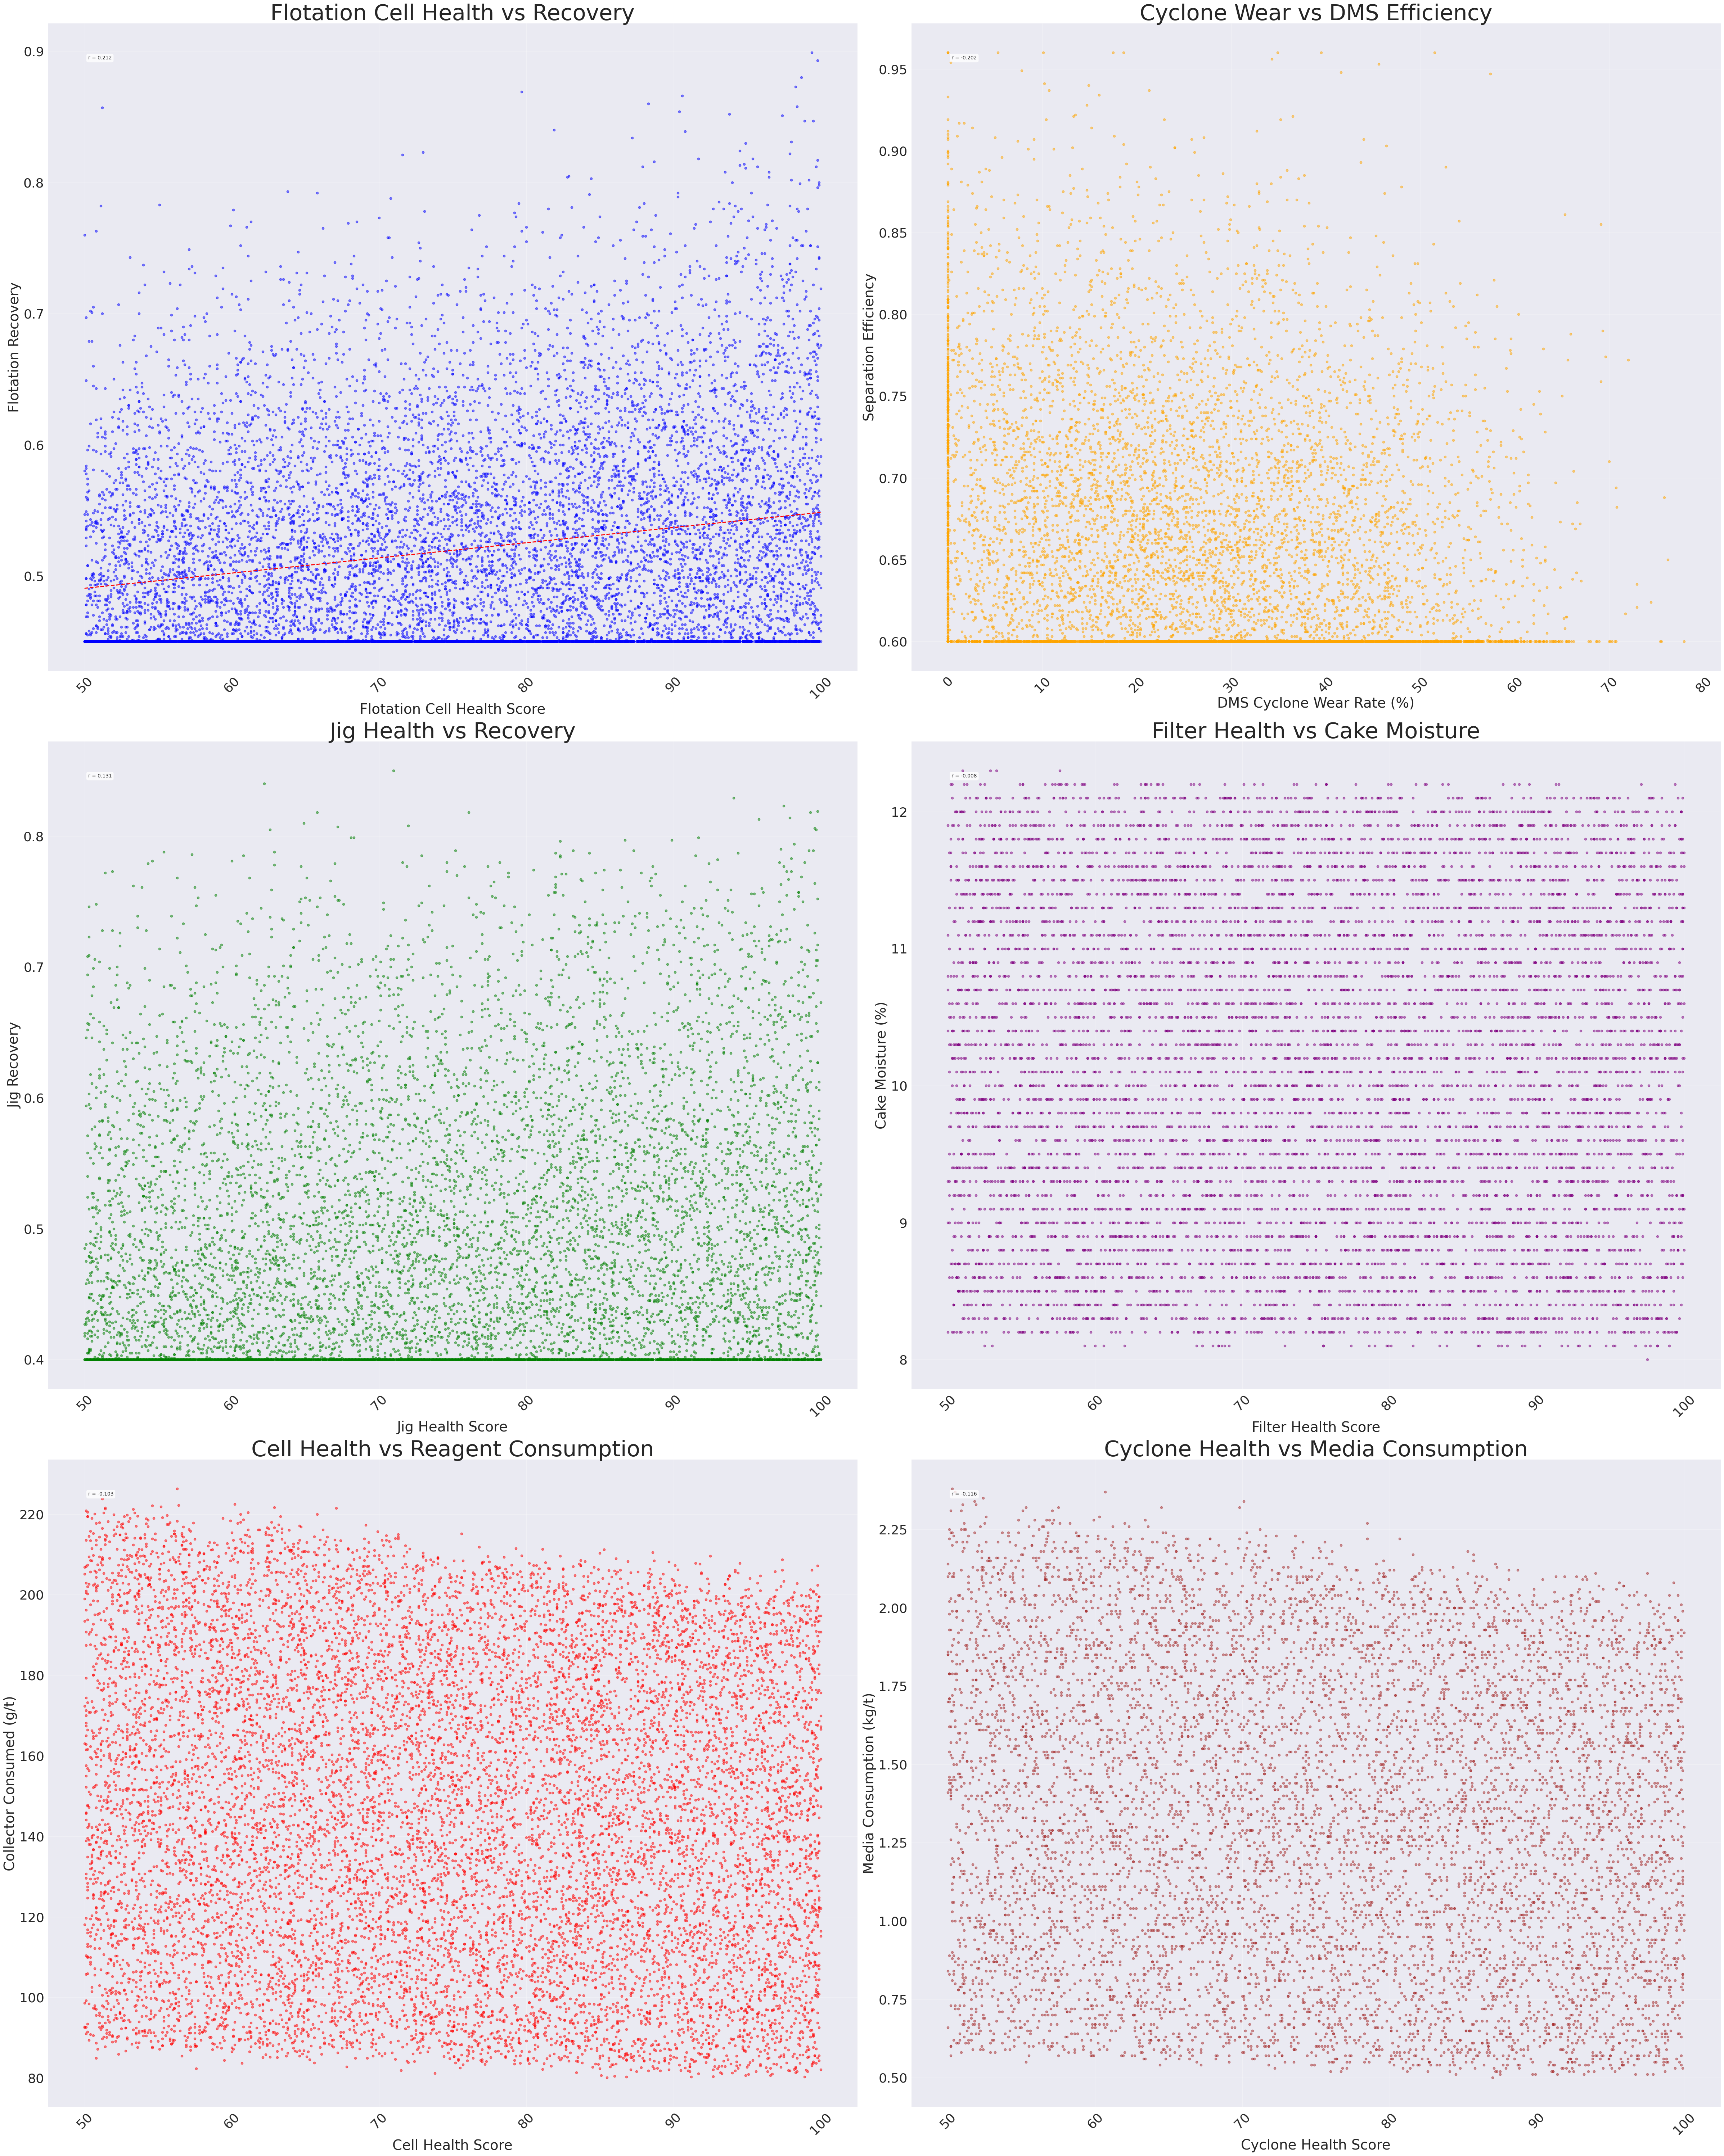


EQUIPMENT-PROCESS CORRELATION SUMMARY:
  Flotation Cell Health → Recovery: 0.212
  DMS Cyclone Wear → Efficiency: -0.202
  Jig Health → Recovery: 0.131
  Filter Health → Cake Moisture: -0.008


In [58]:
# %%
# STEP 7B: EQUIPMENT-PROCESS PERFORMANCE CORRELATION
print("\n" + "=" * 60)
print("EQUIPMENT-PROCESS PERFORMANCE CORRELATION")
print("=" * 60)

fig, axes = plt.subplots(3, 2, figsize=(48, 60))
axes = axes.ravel()

# Common font sizes
title_size = 44
label_size = 28
tick_size = 26

# Flotation: Cell Health vs Recovery
if 'flotation' in datasets:
    flot_df = datasets['flotation']
    if 'cell_health_score' in flot_df.columns:
        axes[0].scatter(flot_df['cell_health_score'], flot_df['flotation_recovery'],
                       alpha=0.5, s=20, c='blue')
        axes[0].set_xlabel('Flotation Cell Health Score', fontsize=label_size)
        axes[0].set_ylabel('Flotation Recovery', fontsize=label_size)
        axes[0].set_title('Flotation Cell Health vs Recovery', fontsize=title_size)
        axes[0].grid(True, alpha=0.3)
        axes[0].tick_params(axis='x', rotation=45, labelsize=tick_size)
        axes[0].tick_params(axis='y', labelsize=tick_size)

        # Add trend line
        z = np.polyfit(flot_df['cell_health_score'], flot_df['flotation_recovery'], 1)
        p = np.poly1d(z)
        axes[0].plot(flot_df['cell_health_score'].sort_values(),
                    p(flot_df['cell_health_score'].sort_values()), "r--", linewidth=2)

        # Correlation
        corr = flot_df['cell_health_score'].corr(flot_df['flotation_recovery'])
        axes[0].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[0].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# DMS: Cyclone Wear vs Separation Efficiency
if 'dms' in datasets:
    dms_df = datasets['dms']
    if 'cyclone_wear_rate_pct' in dms_df.columns:
        axes[1].scatter(dms_df['cyclone_wear_rate_pct'], dms_df['separation_efficiency'],
                       alpha=0.5, s=20, c='orange')
        axes[1].set_xlabel('DMS Cyclone Wear Rate (%)', fontsize=label_size)
        axes[1].set_ylabel('Separation Efficiency', fontsize=label_size)
        axes[1].set_title('Cyclone Wear vs DMS Efficiency', fontsize=title_size)
        axes[1].grid(True, alpha=0.3)
        axes[1].tick_params(axis='x', rotation=45, labelsize=tick_size)
        axes[1].tick_params(axis='y', labelsize=tick_size)

        corr = dms_df['cyclone_wear_rate_pct'].corr(dms_df['separation_efficiency'])
        axes[1].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[1].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Jigging: Jig Health vs Recovery
if 'jigging' in datasets:
    jig_df = datasets['jigging']
    if 'jig_health_score' in jig_df.columns:
        axes[2].scatter(jig_df['jig_health_score'], jig_df['jig_recovery'],
                       alpha=0.5, s=20, c='green')
        axes[2].set_xlabel('Jig Health Score', fontsize=label_size)
        axes[2].set_ylabel('Jig Recovery', fontsize=label_size)
        axes[2].set_title('Jig Health vs Recovery', fontsize=title_size)
        axes[2].grid(True, alpha=0.3)
        axes[2].tick_params(axis='x', rotation=45, labelsize=tick_size)
        axes[2].tick_params(axis='y', labelsize=tick_size)

        corr = jig_df['jig_health_score'].corr(jig_df['jig_recovery'])
        axes[2].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[2].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Dewatering: Filter Health vs Cake Moisture
if 'dewatering' in datasets:
    dew_df = datasets['dewatering']
    if 'filter_health_score' in dew_df.columns:
        axes[3].scatter(dew_df['filter_health_score'], dew_df['cake_moisture_pct'],
                       alpha=0.5, s=20, c='purple')
        axes[3].set_xlabel('Filter Health Score', fontsize=label_size)
        axes[3].set_ylabel('Cake Moisture (%)', fontsize=label_size)
        axes[3].set_title('Filter Health vs Cake Moisture', fontsize=title_size)
        axes[3].grid(True, alpha=0.3)
        axes[3].tick_params(axis='x', rotation=45, labelsize=tick_size)
        axes[3].tick_params(axis='y', labelsize=tick_size)

        corr = dew_df['filter_health_score'].corr(dew_df['cake_moisture_pct'])
        axes[3].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[3].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Flotation: Cell Health vs Reagent Consumption
if 'flotation' in datasets:
    flot_df = datasets['flotation']
    if 'cell_health_score' in flot_df.columns and 'actual_collector_consumed_gt' in flot_df.columns:
        axes[4].scatter(flot_df['cell_health_score'], flot_df['actual_collector_consumed_gt'],
                       alpha=0.5, s=20, c='red')
        axes[4].set_xlabel('Cell Health Score', fontsize=label_size)
        axes[4].set_ylabel('Collector Consumed (g/t)', fontsize=label_size)
        axes[4].set_title('Cell Health vs Reagent Consumption', fontsize=title_size)
        axes[4].grid(True, alpha=0.3)
        axes[4].tick_params(axis='x', rotation=45, labelsize=tick_size)
        axes[4].tick_params(axis='y', labelsize=tick_size)

        corr = flot_df['cell_health_score'].corr(flot_df['actual_collector_consumed_gt'])
        axes[4].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[4].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# DMS: Cyclone Health vs Media Consumption
if 'dms' in datasets:
    dms_df = datasets['dms']
    if 'cyclone_health_score' in dms_df.columns:
        axes[5].scatter(dms_df['cyclone_health_score'], dms_df['media_consumption_kg_t'],
                       alpha=0.5, s=20, c='brown')
        axes[5].set_xlabel('Cyclone Health Score', fontsize=label_size)
        axes[5].set_ylabel('Media Consumption (kg/t)', fontsize=label_size)
        axes[5].set_title('Cyclone Health vs Media Consumption', fontsize=title_size)
        axes[5].grid(True, alpha=0.3)
        axes[5].tick_params(axis='x', rotation=45, labelsize=tick_size)
        axes[5].tick_params(axis='y', labelsize=tick_size)

        corr = dms_df['cyclone_health_score'].corr(dms_df['media_consumption_kg_t'])
        axes[5].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[5].transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Summary statistics
print("\nEQUIPMENT-PROCESS CORRELATION SUMMARY:")
correlations = []

if 'flotation' in datasets and 'cell_health_score' in datasets['flotation'].columns:
    corr = datasets['flotation']['cell_health_score'].corr(datasets['flotation']['flotation_recovery'])
    correlations.append(('Flotation Cell Health → Recovery', corr))

if 'dms' in datasets and 'cyclone_wear_rate_pct' in datasets['dms'].columns:
    corr = datasets['dms']['cyclone_wear_rate_pct'].corr(datasets['dms']['separation_efficiency'])
    correlations.append(('DMS Cyclone Wear → Efficiency', corr))

if 'jigging' in datasets and 'jig_health_score' in datasets['jigging'].columns:
    corr = datasets['jigging']['jig_health_score'].corr(datasets['jigging']['jig_recovery'])
    correlations.append(('Jig Health → Recovery', corr))

if 'dewatering' in datasets and 'filter_health_score' in datasets['dewatering'].columns:
    corr = datasets['dewatering']['filter_health_score'].corr(datasets['dewatering']['cake_moisture_pct'])
    correlations.append(('Filter Health → Cake Moisture', corr))

for relationship, corr_value in correlations:
    print(f"  {relationship}: {corr_value:.3f}")


EQUIPMENT DEGRADATION & PERFORMANCE IMPACT

FLOTATION RECOVERY BY HEALTH CATEGORY:
                   mean     std  count
health_category                       
Excellent        0.5371  0.0869   4817
Fair             0.5010  0.0664   3627
Good             0.5143  0.0734   3556


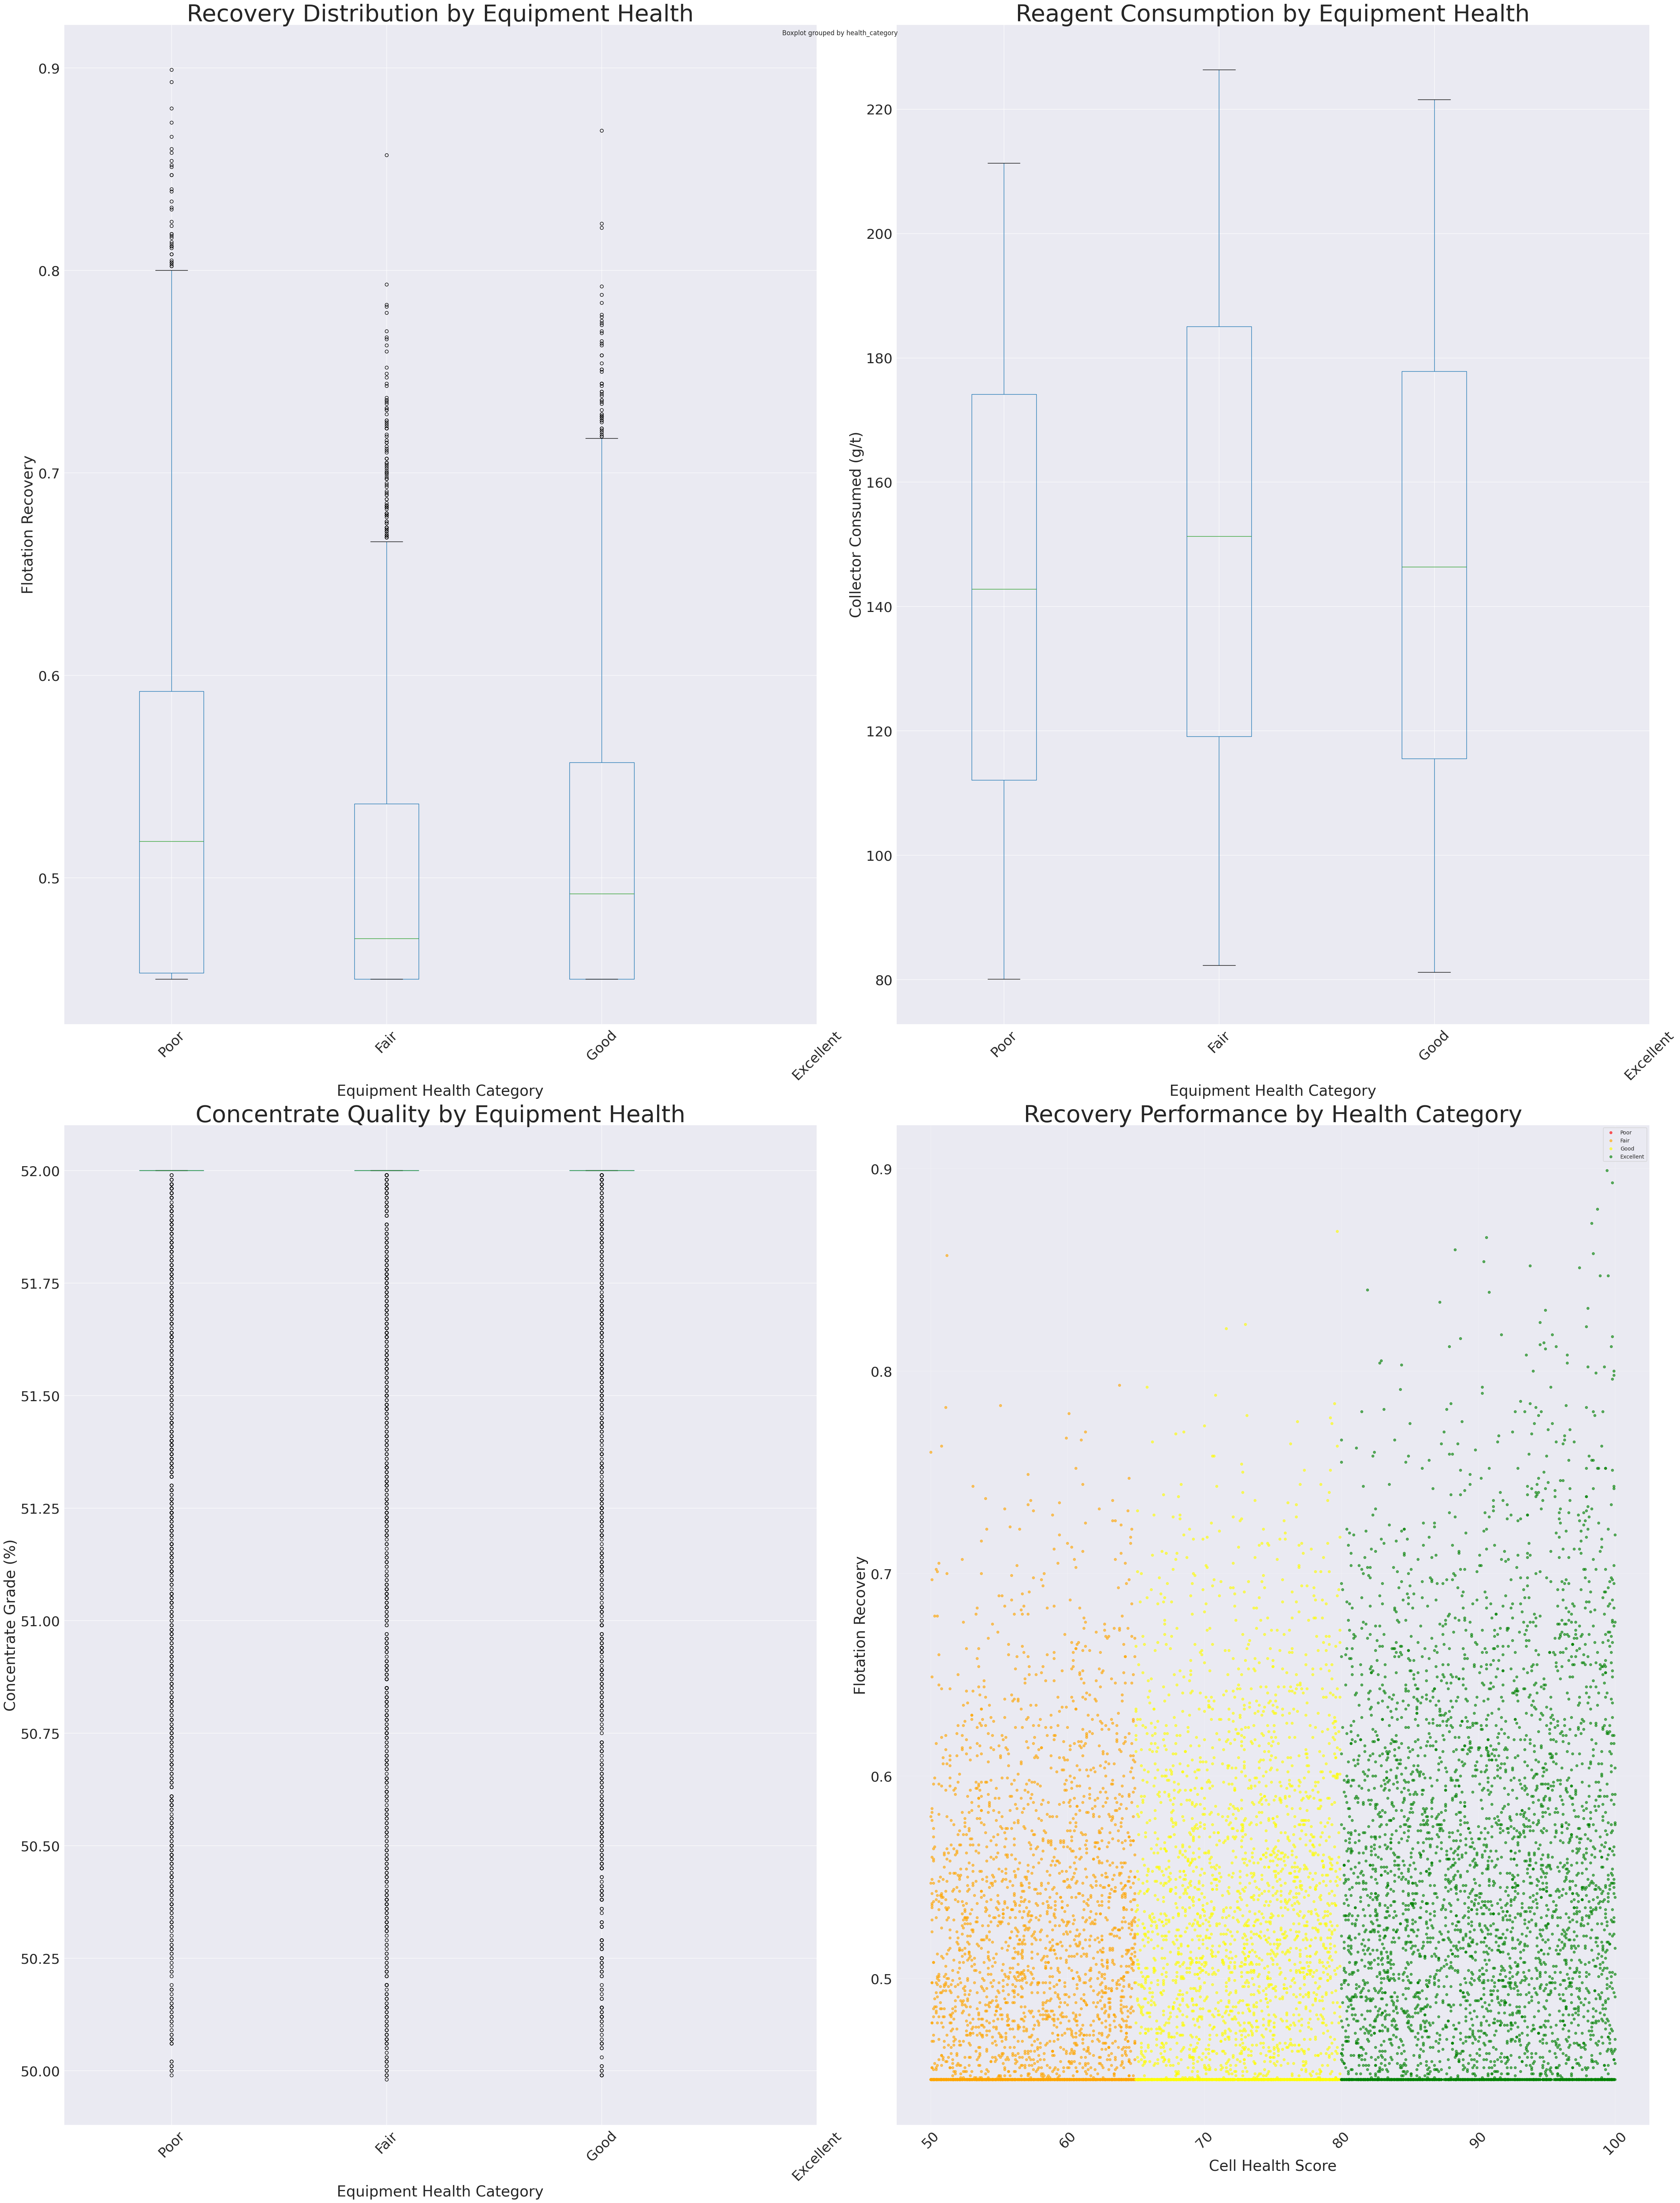


DMS PERFORMANCE BY CYCLONE HEALTH:
                 dms_recovery  separation_efficiency  media_consumption_kg_t
health_category                                                             
Excellent              0.7569                 0.6861                  1.2836
Fair                   0.7560                 0.6484                  1.4049
Good                   0.7572                 0.6666                  1.3589

ANOVA TEST: Equipment Health Impact on Recovery
F-statistic: 238.1049
P-value: 3.9078e-102
Result: Equipment health SIGNIFICANTLY affects recovery (p < 0.05)


In [60]:
# %%
# STEP 7C: EQUIPMENT DEGRADATION ANALYSIS
print("\n" + "=" * 60)
print("EQUIPMENT DEGRADATION & PERFORMANCE IMPACT")
print("=" * 60)

# Categorize equipment by health
def categorize_health(score):
    if score >= 80:
        return 'Excellent'
    elif score >= 65:
        return 'Good'
    elif score >= 50:
        return 'Fair'
    else:
        return 'Poor'

# Common font sizes
title_size = 44
label_size = 28
tick_size = 26

# Flotation recovery by health category
if 'flotation' in datasets:
    flot_df = datasets['flotation'].copy()
    if 'cell_health_score' in flot_df.columns:
        flot_df['health_category'] = flot_df['cell_health_score'].apply(categorize_health)

        fig, axes = plt.subplots(2, 2, figsize=(44, 58))

        # Box plot: Recovery by health category
        health_order = ['Poor', 'Fair', 'Good', 'Excellent']
        flot_df.boxplot(column='flotation_recovery', by='health_category', ax=axes[0,0])
        axes[0,0].set_xlabel('Equipment Health Category', fontsize=label_size)
        axes[0,0].set_ylabel('Flotation Recovery', fontsize=label_size)
        axes[0,0].set_title('Recovery Distribution by Equipment Health', fontsize=title_size)
        plt.sca(axes[0,0])
        axes[0,0].tick_params(axis='x', rotation=45, labelsize=tick_size)
        axes[0,0].tick_params(axis='y', labelsize=tick_size)
        plt.xticks(range(1, len(health_order)+1), health_order)

        # Statistics by category
        recovery_by_health = flot_df.groupby('health_category')['flotation_recovery'].agg(['mean', 'std', 'count'])
        print("\nFLOTATION RECOVERY BY HEALTH CATEGORY:")
        print(recovery_by_health.round(4))

        # Reagent consumption by health category
        if 'actual_collector_consumed_gt' in flot_df.columns:
            flot_df.boxplot(column='actual_collector_consumed_gt', by='health_category', ax=axes[0,1])
            axes[0,1].set_xlabel('Equipment Health Category', fontsize=label_size)
            axes[0,1].set_ylabel('Collector Consumed (g/t)', fontsize=label_size)
            axes[0,1].set_title('Reagent Consumption by Equipment Health', fontsize=title_size)
            plt.sca(axes[0,1])
            axes[0,1].tick_params(axis='x', rotation=45, labelsize=tick_size)
            axes[0,1].tick_params(axis='y', labelsize=tick_size)
            plt.xticks(range(1, len(health_order)+1), health_order)

        # Grade by health category
        flot_df.boxplot(column='concentrate_grade_pct', by='health_category', ax=axes[1,0])
        axes[1,0].set_xlabel('Equipment Health Category', fontsize=label_size)
        axes[1,0].set_ylabel('Concentrate Grade (%)', fontsize=label_size)
        axes[1,0].set_title('Concentrate Quality by Equipment Health', fontsize=title_size)
        plt.sca(axes[1,0])
        plt.xticks(range(1, len(health_order)+1), health_order)
        axes[1,0].tick_params(axis='x', rotation=45, labelsize=tick_size)
        axes[1,0].tick_params(axis='y', labelsize=tick_size)

        # Recovery vs Health scatter with categories
        colors = {'Poor': 'red', 'Fair': 'orange', 'Good': 'yellow', 'Excellent': 'green'}
        for category in health_order:
            mask = flot_df['health_category'] == category
            axes[1,1].scatter(flot_df[mask]['cell_health_score'],
                            flot_df[mask]['flotation_recovery'],
                            c=colors[category], label=category, alpha=0.6, s=20)
        axes[1,1].set_xlabel('Cell Health Score', fontsize=label_size)
        axes[1,1].set_ylabel('Flotation Recovery', fontsize=label_size)
        axes[1,1].set_title('Recovery Performance by Health Category', fontsize=title_size)
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].tick_params(axis='x', rotation=45, labelsize=tick_size)
        axes[1,1].tick_params(axis='y', labelsize=tick_size)

        plt.tight_layout()
        plt.show()

# DMS performance by cyclone health
if 'dms' in datasets:
    dms_df = datasets['dms'].copy()
    if 'cyclone_health_score' in dms_df.columns:
        dms_df['health_category'] = dms_df['cyclone_health_score'].apply(categorize_health)

        print("\nDMS PERFORMANCE BY CYCLONE HEALTH:")
        dms_by_health = dms_df.groupby('health_category')[['dms_recovery', 'separation_efficiency',
                                                           'media_consumption_kg_t']].mean()
        print(dms_by_health.round(4))

# Statistical significance test (ANOVA)
if 'flotation' in datasets and 'cell_health_score' in datasets['flotation'].columns:
    from scipy.stats import f_oneway

    flot_df = datasets['flotation'].copy()
    flot_df['health_category'] = flot_df['cell_health_score'].apply(categorize_health)

    groups = [group['flotation_recovery'].values for name, group in flot_df.groupby('health_category')]
    f_stat, p_value = f_oneway(*groups)

    print(f"\nANOVA TEST: Equipment Health Impact on Recovery")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4e}")
    if p_value < 0.05:
        print("Result: Equipment health SIGNIFICANTLY affects recovery (p < 0.05)")
    else:
        print("Result: No significant effect detected")